In [1]:
import numpy as np
import pandas as pd
from talib import abstract

In [2]:
data = pd.read_csv('/Users/chungyu/畢業/0056.TW.csv')
data.set_index(pd.to_datetime(data['Date'],format='%Y/%m/%d'),inplace=True)

data

,Date,Open,High,Low,Close,Volume
Date,,,,,,
2007-12-26,2007/12/26,25.10,25.20,24.95,25.15,2354
2007-12-27,2007/12/27,25.15,25.58,25.15,25.43,10964
2007-12-28,2007/12/28,25.53,25.66,25.40,25.60,9327
2007-12-31,2007/12/31,25.70,26.05,25.70,26.04,3441
2008-01-02,2008/1/2,26.00,26.15,25.70,25.75,3825
...,...,...,...,...,...,...
2022-11-24,2022/11/24,25.40,25.54,25.38,25.54,16108
2022-11-25,2022/11/25,25.57,25.65,25.50,25.52,20109
2022-11-28,2022/11/28,25.32,25.42,25.17,25.32,26452


In [3]:
def draw_fig(data):
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure(figsize=(20,5))
    plt.title('Close')
    plt.plot(data['Close'])
    plt.show()
    

In [4]:
def data_process(data):
    from talib import abstract
#股價漲跌幅
    DeltaClose = data["Close"].diff(1)
    data["股價漲跌幅"] = DeltaClose / data["Close"]

#布林通道帶寬 (均線週期、上軌標準差倍數、下軌標準差倍數、均線種類 tip31、tip40) 0 => SMA
    UpperBand,MiddleBand,DownBand = abstract.BBANDS(data["Close"], timeperiod=5, nbdevup=2.0, nbdevdn=2.0, matype=0)
    data["布林通道帶寬"] = (UpperBand-DownBand) / MiddleBand


#ＳＭＡ
    data["SMA5"] = abstract.SMA(data["Close"],timeperiod = 5)
    data["SMA10"] = abstract.SMA(data["Close"],timeperiod = 10)
    data["SMA20"] = abstract.SMA(data["Close"],timeperiod = 20)
    data["SMA60"] = abstract.SMA(data["Close"],timeperiod = 60)

#ＥＭＡ
    data["EMA5"] = abstract.EMA(data["Close"],timeperiod = 5)
    data["EMA10"] = abstract.EMA(data["Close"],timeperiod = 10)
    data["EMA20"] = abstract.EMA(data["Close"],timeperiod = 20)
    data["EMA60"] = abstract.EMA(data["Close"],timeperiod = 60)

#ＫＤ指標（ＳＴＯＣＨ）（週期、Ｋ值分母、Ｄ值分母）
    data["K"],data["D"] = abstract.STOCH(data["High"],data["Low"],data["Close"],fastk_period = 9, slowk_period = 3, slowd_period = 3)

#RSI
    data["RSI5"] = abstract.RSI(data["Close"],timeperiod = 5)
    data["RSI10"] = abstract.RSI(data["Close"],timeperiod = 10)

#MACD （短均線週期、長均線週期、ＭＡＣＤ週期）OSC＝DIF-MACD
    DIF,MACD,OSC = abstract.MACD(data["Close"],fastperiod = 12, slowperiod = 26, signalperiod = 9)
    data["MACD"] = OSC

#威廉指標
    data["WILLAR5"] = abstract.WILLR(data["High"],data["Low"],data["Close"],timeperiod = 5)
    data["WILLAR10"] = abstract.WILLR(data["High"],data["Low"],data["Close"],timeperiod = 10)
    
    return data

In [5]:
data

,Date,Open,High,Low,Close,Volume
Date,,,,,,
2007-12-26,2007/12/26,25.10,25.20,24.95,25.15,2354
2007-12-27,2007/12/27,25.15,25.58,25.15,25.43,10964
2007-12-28,2007/12/28,25.53,25.66,25.40,25.60,9327
2007-12-31,2007/12/31,25.70,26.05,25.70,26.04,3441
2008-01-02,2008/1/2,26.00,26.15,25.70,25.75,3825
...,...,...,...,...,...,...
2022-11-24,2022/11/24,25.40,25.54,25.38,25.54,16108
2022-11-25,2022/11/25,25.57,25.65,25.50,25.52,20109
2022-11-28,2022/11/28,25.32,25.42,25.17,25.32,26452


In [6]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif


def split_data(data,start_time,end_time,features,k):
    #輸入特徵值
    X = data.loc[start_time:end_time,features]
    
    y_data = data.loc[start_time : end_time,['股價漲跌幅']]
    Y = np.where(y_data.shift(-1)>0 ,0, 1)
    
    #特徵篩選（ANOVA）
    k_best = SelectKBest(score_func=f_classif ,k = k)
    X_new = k_best.fit_transform(X,np.ravel(Y))

    selected_features = k_best.get_support(indices=True)
    print(selected_features)

    X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size =0.2, random_state = 0 )
    return X_train,X_test, y_train, y_test



In [7]:
def RandomForest(X_train,X_test,y_train,y_test):
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=2000, random_state=10, n_jobs=-1 , min_samples_leaf=5)
    
    model = clf.fit(X_train,np.ravel(y_train))
    y_pre = clf.predict(X_test)
    
    from sklearn.metrics import classification_report
    report = classification_report(y_test,y_pre)
    print(report)
    print('RandomForestClassifier')

   
    return y_test, y_pre

   

In [8]:
from sklearn.metrics import accuracy_score
def auc_roc(y_test, y_pre):  
    from sklearn import metrics
    # 績效
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pre)
    auc = metrics.auc(fpr, tpr)
    print('auc = ',auc)
    import matplotlib.pyplot as plt
    
    accuracy = accuracy_score(y_test , y_pre)
    print("accuracy:",accuracy)
    
    plt.plot(fpr,tpr,label="random forest, auc="+str(auc),color='orange')
    plt.title("ROC")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc=4)
    plt.show()

In [9]:
#全樣本

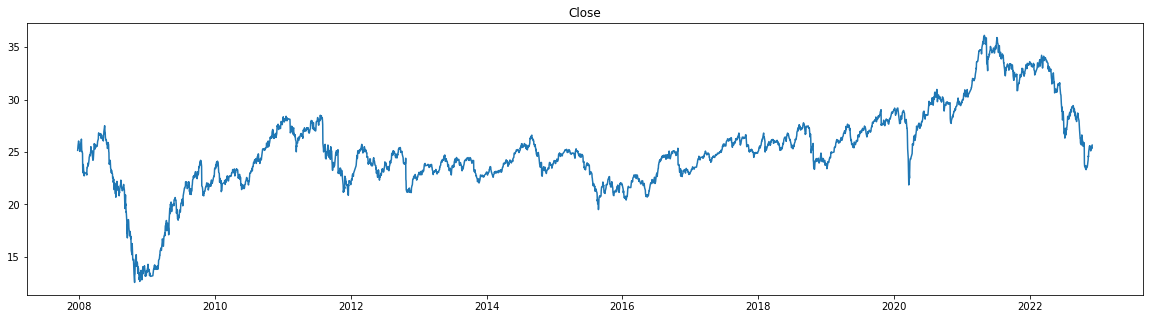

[ 0 12 13 15 16]
              precision    recall  f1-score   support

           0       0.55      0.58      0.56       392
           1       0.47      0.44      0.46       333

    accuracy                           0.52       725
   macro avg       0.51      0.51      0.51       725
weighted avg       0.51      0.52      0.51       725

RandomForestClassifier
auc =  0.5104875283446711
accuracy: 0.5158620689655172


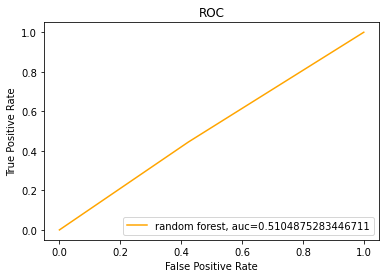

In [10]:
data = data_process(data)

draw_fig(data)

X_train,X_test,y_train,y_test = split_data(data,'2008-04-01','2022-11-30',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)

auc_roc(y_test_RF, y_pre_RF)


In [11]:
#根據台灣加權指數分割時間
#2008-06-01~2008-12-31 0.4 (0.43)
#2009-01-01~2010-01-31 0.63 (0.65)
#2010-06-01','2011-01-31 0.54 (0.6)
#美債危機'2011-08-01','2011-12-31' 0.41 (0.41)
#逐漸上升2012-06-01~2015-03-30 0.5 (0.54)
#2015中國股災2015-04-01~2015-08-31 0.58 (0.62)
#逐漸上升2016-01-01~2017-12-31 0.46 (0.47)
#中美貿易戰2018-10-01~2019-01-14 0.53 (0.53)
#Covid-19 2020-01-01~2020-03-30 0.54 (0.64)
#疫情後報復性反彈 2020-03-20~2021-12-31 0.50(0.51)
#2022大動盪2022-01-01~2022-11-30 0.50(0.47)

[ 0  1 11 14 15]
              precision    recall  f1-score   support

           0       0.14      0.05      0.08        19
           1       0.44      0.70      0.54        20

    accuracy                           0.38        39
   macro avg       0.29      0.38      0.31        39
weighted avg       0.29      0.38      0.31        39

RandomForestClassifier
auc =  0.3763157894736842
accuracy: 0.38461538461538464


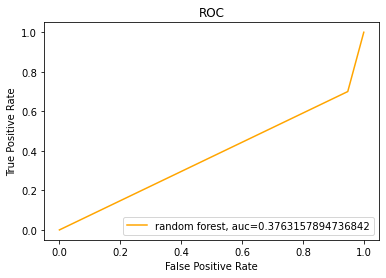

[I 2023-03-08 09:42:40,796] A new study created in memory with name: no-name-411fe33f-2757-4b85-8b7a-70011fb1153b
[I 2023-03-08 09:42:42,316] Trial 0 finished with value: 0.38461538461538464 and parameters: {'n_estimators': 1106, 'min_samoles_leaf': 6}. Best is trial 0 with value: 0.38461538461538464.
[I 2023-03-08 09:42:42,785] Trial 1 finished with value: 0.41025641025641024 and parameters: {'n_estimators': 341, 'min_samoles_leaf': 6}. Best is trial 1 with value: 0.41025641025641024.
[I 2023-03-08 09:42:44,028] Trial 2 finished with value: 0.4358974358974359 and parameters: {'n_estimators': 921, 'min_samoles_leaf': 13}. Best is trial 2 with value: 0.4358974358974359.
[I 2023-03-08 09:42:44,291] Trial 3 finished with value: 0.4358974358974359 and parameters: {'n_estimators': 184, 'min_samoles_leaf': 6}. Best is trial 2 with value: 0.4358974358974359.
[I 2023-03-08 09:42:45,066] Trial 4 finished with value: 0.41025641025641024 and parameters: {'n_estimators': 562, 'min_samoles_leaf': 7

[I 2023-03-08 09:43:37,439] Trial 41 finished with value: 0.4358974358974359 and parameters: {'n_estimators': 1822, 'min_samoles_leaf': 12}. Best is trial 2 with value: 0.4358974358974359.
[I 2023-03-08 09:43:40,084] Trial 42 finished with value: 0.4358974358974359 and parameters: {'n_estimators': 1994, 'min_samoles_leaf': 12}. Best is trial 2 with value: 0.4358974358974359.
[I 2023-03-08 09:43:42,332] Trial 43 finished with value: 0.4358974358974359 and parameters: {'n_estimators': 1693, 'min_samoles_leaf': 13}. Best is trial 2 with value: 0.4358974358974359.
[I 2023-03-08 09:43:44,324] Trial 44 finished with value: 0.4358974358974359 and parameters: {'n_estimators': 1496, 'min_samoles_leaf': 11}. Best is trial 2 with value: 0.4358974358974359.
[I 2023-03-08 09:43:44,671] Trial 45 finished with value: 0.4358974358974359 and parameters: {'n_estimators': 250, 'min_samoles_leaf': 15}. Best is trial 2 with value: 0.4358974358974359.
[I 2023-03-08 09:43:45,809] Trial 46 finished with value

[I 2023-03-08 09:44:30,235] Trial 82 finished with value: 0.4358974358974359 and parameters: {'n_estimators': 848, 'min_samoles_leaf': 14}. Best is trial 2 with value: 0.4358974358974359.
[I 2023-03-08 09:44:31,529] Trial 83 finished with value: 0.4358974358974359 and parameters: {'n_estimators': 963, 'min_samoles_leaf': 12}. Best is trial 2 with value: 0.4358974358974359.
[I 2023-03-08 09:44:32,427] Trial 84 finished with value: 0.4358974358974359 and parameters: {'n_estimators': 661, 'min_samoles_leaf': 13}. Best is trial 2 with value: 0.4358974358974359.
[I 2023-03-08 09:44:33,821] Trial 85 finished with value: 0.4358974358974359 and parameters: {'n_estimators': 1039, 'min_samoles_leaf': 13}. Best is trial 2 with value: 0.4358974358974359.
[I 2023-03-08 09:44:34,171] Trial 86 finished with value: 0.4358974358974359 and parameters: {'n_estimators': 246, 'min_samoles_leaf': 12}. Best is trial 2 with value: 0.4358974358974359.
[I 2023-03-08 09:44:35,189] Trial 87 finished with value: 0

準確度： 0.4358974358974359
最佳參數 {'n_estimators': 921, 'min_samoles_leaf': 13}


In [12]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2008-04-01','2008-12-31',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)

auc_roc(y_test_RF, y_pre_RF)

from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)

[2 3 6 7 8]


[I 2023-03-08 09:44:57,448] A new study created in memory with name: no-name-b048ee1e-09cd-435b-ade0-00b65a2bf249


              precision    recall  f1-score   support

           0       0.71      0.74      0.72        34
           1       0.55      0.52      0.54        21

    accuracy                           0.65        55
   macro avg       0.63      0.63      0.63        55
weighted avg       0.65      0.65      0.65        55

RandomForestClassifier


[I 2023-03-08 09:44:59,603] Trial 0 finished with value: 0.7090909090909091 and parameters: {'n_estimators': 1588, 'min_samoles_leaf': 10}. Best is trial 0 with value: 0.7090909090909091.
[I 2023-03-08 09:44:59,840] Trial 1 finished with value: 0.7090909090909091 and parameters: {'n_estimators': 174, 'min_samoles_leaf': 15}. Best is trial 0 with value: 0.7090909090909091.
[I 2023-03-08 09:45:01,411] Trial 2 finished with value: 0.7090909090909091 and parameters: {'n_estimators': 1194, 'min_samoles_leaf': 15}. Best is trial 0 with value: 0.7090909090909091.
[I 2023-03-08 09:45:04,194] Trial 3 finished with value: 0.6727272727272727 and parameters: {'n_estimators': 1984, 'min_samoles_leaf': 13}. Best is trial 0 with value: 0.7090909090909091.
[I 2023-03-08 09:45:05,403] Trial 4 finished with value: 0.6181818181818182 and parameters: {'n_estimators': 809, 'min_samoles_leaf': 5}. Best is trial 0 with value: 0.7090909090909091.
[I 2023-03-08 09:45:07,128] Trial 5 finished with value: 0.6727

[I 2023-03-08 09:46:09,098] Trial 41 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 1289, 'min_samoles_leaf': 7}. Best is trial 6 with value: 0.7272727272727273.
[I 2023-03-08 09:46:11,188] Trial 42 finished with value: 0.6909090909090909 and parameters: {'n_estimators': 1479, 'min_samoles_leaf': 6}. Best is trial 6 with value: 0.7272727272727273.
[I 2023-03-08 09:46:12,898] Trial 43 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 1250, 'min_samoles_leaf': 7}. Best is trial 6 with value: 0.7272727272727273.
[I 2023-03-08 09:46:14,490] Trial 44 finished with value: 0.6909090909090909 and parameters: {'n_estimators': 1168, 'min_samoles_leaf': 9}. Best is trial 6 with value: 0.7272727272727273.
[I 2023-03-08 09:46:16,344] Trial 45 finished with value: 0.6727272727272727 and parameters: {'n_estimators': 1365, 'min_samoles_leaf': 12}. Best is trial 6 with value: 0.7272727272727273.
[I 2023-03-08 09:46:17,822] Trial 46 finished with value: 0

[I 2023-03-08 09:47:23,285] Trial 82 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 1149, 'min_samoles_leaf': 7}. Best is trial 6 with value: 0.7272727272727273.
[I 2023-03-08 09:47:25,445] Trial 83 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 1560, 'min_samoles_leaf': 8}. Best is trial 6 with value: 0.7272727272727273.
[I 2023-03-08 09:47:27,516] Trial 84 finished with value: 0.6909090909090909 and parameters: {'n_estimators': 1443, 'min_samoles_leaf': 6}. Best is trial 6 with value: 0.7272727272727273.
[I 2023-03-08 09:47:29,556] Trial 85 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 1495, 'min_samoles_leaf': 7}. Best is trial 6 with value: 0.7272727272727273.
[I 2023-03-08 09:47:30,853] Trial 86 finished with value: 0.7090909090909091 and parameters: {'n_estimators': 916, 'min_samoles_leaf': 8}. Best is trial 6 with value: 0.7272727272727273.
[I 2023-03-08 09:47:32,844] Trial 87 finished with value: 0.6

準確度： 0.7272727272727273
最佳參數 {'n_estimators': 1543, 'min_samoles_leaf': 8}
auc =  0.6295518207282913
accuracy: 0.6545454545454545


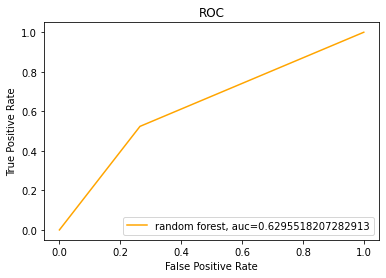

In [13]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2009-01-01','2010-01-31',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)

from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)

auc_roc(y_test_RF, y_pre_RF)

[10 11 12 13 16]


[I 2023-03-08 09:47:58,348] A new study created in memory with name: no-name-779d3613-d0bc-4569-ad5e-a7ac3ea31464


              precision    recall  f1-score   support

           0       0.17      0.40      0.24         5
           1       0.70      0.41      0.52        17

    accuracy                           0.41        22
   macro avg       0.43      0.41      0.38        22
weighted avg       0.58      0.41      0.45        22

RandomForestClassifier


[I 2023-03-08 09:47:58,570] Trial 0 finished with value: 0.5454545454545454 and parameters: {'n_estimators': 168, 'min_samoles_leaf': 14}. Best is trial 0 with value: 0.5454545454545454.
[I 2023-03-08 09:48:00,491] Trial 1 finished with value: 0.45454545454545453 and parameters: {'n_estimators': 1511, 'min_samoles_leaf': 11}. Best is trial 0 with value: 0.5454545454545454.
[I 2023-03-08 09:48:02,187] Trial 2 finished with value: 0.45454545454545453 and parameters: {'n_estimators': 1300, 'min_samoles_leaf': 9}. Best is trial 0 with value: 0.5454545454545454.
[I 2023-03-08 09:48:03,717] Trial 3 finished with value: 0.4090909090909091 and parameters: {'n_estimators': 1168, 'min_samoles_leaf': 6}. Best is trial 0 with value: 0.5454545454545454.
[I 2023-03-08 09:48:04,727] Trial 4 finished with value: 0.45454545454545453 and parameters: {'n_estimators': 778, 'min_samoles_leaf': 9}. Best is trial 0 with value: 0.5454545454545454.
[I 2023-03-08 09:48:07,066] Trial 5 finished with value: 0.545

[I 2023-03-08 09:48:57,360] Trial 42 finished with value: 0.5 and parameters: {'n_estimators': 1597, 'min_samoles_leaf': 14}. Best is trial 0 with value: 0.5454545454545454.
[I 2023-03-08 09:48:59,805] Trial 43 finished with value: 0.5454545454545454 and parameters: {'n_estimators': 1900, 'min_samoles_leaf': 15}. Best is trial 0 with value: 0.5454545454545454.
[I 2023-03-08 09:49:01,660] Trial 44 finished with value: 0.4090909090909091 and parameters: {'n_estimators': 1357, 'min_samoles_leaf': 7}. Best is trial 0 with value: 0.5454545454545454.
[I 2023-03-08 09:49:03,624] Trial 45 finished with value: 0.5 and parameters: {'n_estimators': 1525, 'min_samoles_leaf': 14}. Best is trial 0 with value: 0.5454545454545454.
[I 2023-03-08 09:49:05,712] Trial 46 finished with value: 0.45454545454545453 and parameters: {'n_estimators': 1619, 'min_samoles_leaf': 13}. Best is trial 0 with value: 0.5454545454545454.
[I 2023-03-08 09:49:06,360] Trial 47 finished with value: 0.5454545454545454 and para

[I 2023-03-08 09:49:42,037] Trial 84 finished with value: 0.5454545454545454 and parameters: {'n_estimators': 123, 'min_samoles_leaf': 15}. Best is trial 0 with value: 0.5454545454545454.
[I 2023-03-08 09:49:42,314] Trial 85 finished with value: 0.5454545454545454 and parameters: {'n_estimators': 198, 'min_samoles_leaf': 14}. Best is trial 0 with value: 0.5454545454545454.
[I 2023-03-08 09:49:44,692] Trial 86 finished with value: 0.4090909090909091 and parameters: {'n_estimators': 1781, 'min_samoles_leaf': 5}. Best is trial 0 with value: 0.5454545454545454.
[I 2023-03-08 09:49:46,725] Trial 87 finished with value: 0.5 and parameters: {'n_estimators': 1579, 'min_samoles_leaf': 14}. Best is trial 0 with value: 0.5454545454545454.
[I 2023-03-08 09:49:47,069] Trial 88 finished with value: 0.5454545454545454 and parameters: {'n_estimators': 249, 'min_samoles_leaf': 15}. Best is trial 0 with value: 0.5454545454545454.
[I 2023-03-08 09:49:47,581] Trial 89 finished with value: 0.54545454545454

準確度： 0.5454545454545454
最佳參數 {'n_estimators': 168, 'min_samoles_leaf': 14}
auc =  0.40588235294117647
accuracy: 0.4090909090909091


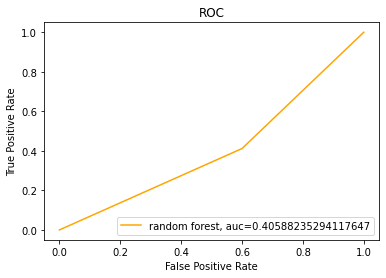

In [14]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2011-08-01','2011-12-31',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)
from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)

auc_roc(y_test_RF, y_pre_RF)

[ 0  1 10 11 14]


[I 2023-03-08 09:49:56,537] A new study created in memory with name: no-name-a8431667-db86-4bb6-bc0c-e91561264640


              precision    recall  f1-score   support

           0       0.60      0.33      0.43         9
           1       0.62      0.83      0.71        12

    accuracy                           0.62        21
   macro avg       0.61      0.58      0.57        21
weighted avg       0.61      0.62      0.59        21

RandomForestClassifier


[I 2023-03-08 09:49:58,923] Trial 0 finished with value: 0.42857142857142855 and parameters: {'n_estimators': 1876, 'min_samoles_leaf': 15}. Best is trial 0 with value: 0.42857142857142855.
[I 2023-03-08 09:50:01,185] Trial 1 finished with value: 0.42857142857142855 and parameters: {'n_estimators': 1783, 'min_samoles_leaf': 14}. Best is trial 0 with value: 0.42857142857142855.
[I 2023-03-08 09:50:01,365] Trial 2 finished with value: 0.42857142857142855 and parameters: {'n_estimators': 135, 'min_samoles_leaf': 12}. Best is trial 0 with value: 0.42857142857142855.
[I 2023-03-08 09:50:03,183] Trial 3 finished with value: 0.5714285714285714 and parameters: {'n_estimators': 1387, 'min_samoles_leaf': 7}. Best is trial 3 with value: 0.5714285714285714.
[I 2023-03-08 09:50:04,343] Trial 4 finished with value: 0.42857142857142855 and parameters: {'n_estimators': 904, 'min_samoles_leaf': 11}. Best is trial 3 with value: 0.5714285714285714.
[I 2023-03-08 09:50:05,430] Trial 5 finished with value:

[I 2023-03-08 09:50:59,456] Trial 41 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 1671, 'min_samoles_leaf': 5}. Best is trial 11 with value: 0.6190476190476191.
[I 2023-03-08 09:51:01,514] Trial 42 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 1551, 'min_samoles_leaf': 5}. Best is trial 11 with value: 0.6190476190476191.
[I 2023-03-08 09:51:03,359] Trial 43 finished with value: 0.5714285714285714 and parameters: {'n_estimators': 1407, 'min_samoles_leaf': 6}. Best is trial 11 with value: 0.6190476190476191.
[I 2023-03-08 09:51:04,926] Trial 44 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 1180, 'min_samoles_leaf': 5}. Best is trial 11 with value: 0.6190476190476191.
[I 2023-03-08 09:51:05,977] Trial 45 finished with value: 0.5714285714285714 and parameters: {'n_estimators': 791, 'min_samoles_leaf': 6}. Best is trial 11 with value: 0.6190476190476191.
[I 2023-03-08 09:51:08,436] Trial 46 finished with value

[I 2023-03-08 09:52:10,645] Trial 82 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 538, 'min_samoles_leaf': 5}. Best is trial 11 with value: 0.6190476190476191.
[I 2023-03-08 09:52:11,105] Trial 83 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 330, 'min_samoles_leaf': 5}. Best is trial 11 with value: 0.6190476190476191.
[I 2023-03-08 09:52:12,144] Trial 84 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 769, 'min_samoles_leaf': 5}. Best is trial 11 with value: 0.6190476190476191.
[I 2023-03-08 09:52:12,995] Trial 85 finished with value: 0.5714285714285714 and parameters: {'n_estimators': 632, 'min_samoles_leaf': 6}. Best is trial 11 with value: 0.6190476190476191.
[I 2023-03-08 09:52:13,581] Trial 86 finished with value: 0.5714285714285714 and parameters: {'n_estimators': 428, 'min_samoles_leaf': 6}. Best is trial 11 with value: 0.6190476190476191.
[I 2023-03-08 09:52:14,494] Trial 87 finished with value: 0.

準確度： 0.6190476190476191
最佳參數 {'n_estimators': 1096, 'min_samoles_leaf': 5}
auc =  0.5833333333333335
accuracy: 0.6190476190476191


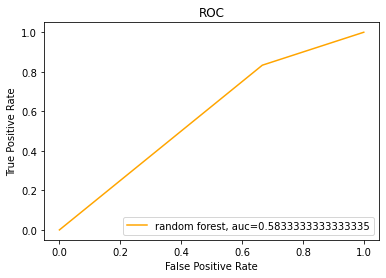

In [15]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2015-04-01','2015-08-31',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)
from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)

auc_roc(y_test_RF, y_pre_RF)

[ 2  6  7 10 11]


[I 2023-03-08 09:52:32,730] A new study created in memory with name: no-name-d12973e9-61f5-4ad2-a460-7846e8e6401e


              precision    recall  f1-score   support

           0       0.62      0.56      0.59         9
           1       0.43      0.50      0.46         6

    accuracy                           0.53        15
   macro avg       0.53      0.53      0.52        15
weighted avg       0.55      0.53      0.54        15

RandomForestClassifier


[I 2023-03-08 09:52:35,238] Trial 0 finished with value: 0.4 and parameters: {'n_estimators': 1973, 'min_samoles_leaf': 8}. Best is trial 0 with value: 0.4.
[I 2023-03-08 09:52:37,184] Trial 1 finished with value: 0.4666666666666667 and parameters: {'n_estimators': 1552, 'min_samoles_leaf': 11}. Best is trial 1 with value: 0.4666666666666667.
[I 2023-03-08 09:52:39,710] Trial 2 finished with value: 0.4 and parameters: {'n_estimators': 1944, 'min_samoles_leaf': 9}. Best is trial 1 with value: 0.4666666666666667.
[I 2023-03-08 09:52:40,871] Trial 3 finished with value: 0.4666666666666667 and parameters: {'n_estimators': 939, 'min_samoles_leaf': 15}. Best is trial 1 with value: 0.4666666666666667.
[I 2023-03-08 09:52:42,352] Trial 4 finished with value: 0.4666666666666667 and parameters: {'n_estimators': 1141, 'min_samoles_leaf': 6}. Best is trial 1 with value: 0.4666666666666667.
[I 2023-03-08 09:52:43,964] Trial 5 finished with value: 0.5333333333333333 and parameters: {'n_estimators': 

[I 2023-03-08 09:53:49,495] Trial 42 finished with value: 0.5333333333333333 and parameters: {'n_estimators': 1550, 'min_samoles_leaf': 5}. Best is trial 5 with value: 0.5333333333333333.
[I 2023-03-08 09:53:51,255] Trial 43 finished with value: 0.4666666666666667 and parameters: {'n_estimators': 1345, 'min_samoles_leaf': 6}. Best is trial 5 with value: 0.5333333333333333.
[I 2023-03-08 09:53:53,560] Trial 44 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 1793, 'min_samoles_leaf': 7}. Best is trial 5 with value: 0.5333333333333333.
[I 2023-03-08 09:53:55,728] Trial 45 finished with value: 0.5333333333333333 and parameters: {'n_estimators': 1658, 'min_samoles_leaf': 5}. Best is trial 5 with value: 0.5333333333333333.
[I 2023-03-08 09:53:57,695] Trial 46 finished with value: 0.4666666666666667 and parameters: {'n_estimators': 1499, 'min_samoles_leaf': 6}. Best is trial 5 with value: 0.5333333333333333.
[I 2023-03-08 09:53:58,829] Trial 47 finished with value: 0.

[I 2023-03-08 09:55:09,335] Trial 83 finished with value: 0.5333333333333333 and parameters: {'n_estimators': 1940, 'min_samoles_leaf': 5}. Best is trial 5 with value: 0.5333333333333333.
[I 2023-03-08 09:55:11,513] Trial 84 finished with value: 0.4666666666666667 and parameters: {'n_estimators': 1665, 'min_samoles_leaf': 6}. Best is trial 5 with value: 0.5333333333333333.
[I 2023-03-08 09:55:13,435] Trial 85 finished with value: 0.5333333333333333 and parameters: {'n_estimators': 1460, 'min_samoles_leaf': 5}. Best is trial 5 with value: 0.5333333333333333.
[I 2023-03-08 09:55:15,246] Trial 86 finished with value: 0.4666666666666667 and parameters: {'n_estimators': 1376, 'min_samoles_leaf': 6}. Best is trial 5 with value: 0.5333333333333333.
[I 2023-03-08 09:55:17,312] Trial 87 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 1599, 'min_samoles_leaf': 7}. Best is trial 5 with value: 0.5333333333333333.
[I 2023-03-08 09:55:19,754] Trial 88 finished with value: 0.

準確度： 0.5333333333333333
最佳參數 {'n_estimators': 1237, 'min_samoles_leaf': 5}
auc =  0.5277777777777778
accuracy: 0.5333333333333333


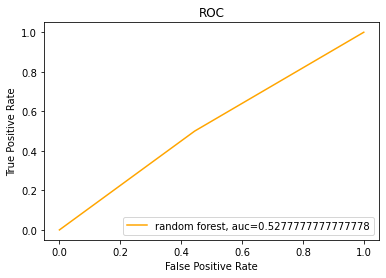

In [16]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2018-10-01','2019-01-14',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)
from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)

auc_roc(y_test_RF, y_pre_RF)

[ 5 12 13 15 16]


[I 2023-03-08 09:55:44,542] A new study created in memory with name: no-name-bd19f191-4e61-48d7-a712-91f00a341030


              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.75      0.75      0.75         8

    accuracy                           0.64        11
   macro avg       0.54      0.54      0.54        11
weighted avg       0.64      0.64      0.64        11

RandomForestClassifier


[I 2023-03-08 09:55:45,102] Trial 0 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 467, 'min_samoles_leaf': 14}. Best is trial 0 with value: 0.7272727272727273.
[I 2023-03-08 09:55:45,348] Trial 1 finished with value: 0.8181818181818182 and parameters: {'n_estimators': 193, 'min_samoles_leaf': 9}. Best is trial 1 with value: 0.8181818181818182.
[I 2023-03-08 09:55:46,310] Trial 2 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 831, 'min_samoles_leaf': 15}. Best is trial 1 with value: 0.8181818181818182.
[I 2023-03-08 09:55:47,759] Trial 3 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 1258, 'min_samoles_leaf': 15}. Best is trial 1 with value: 0.8181818181818182.
[I 2023-03-08 09:55:48,017] Trial 4 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 202, 'min_samoles_leaf': 8}. Best is trial 1 with value: 0.8181818181818182.
[I 2023-03-08 09:55:49,544] Trial 5 finished with value: 0.8181818

[I 2023-03-08 09:56:25,939] Trial 41 finished with value: 0.8181818181818182 and parameters: {'n_estimators': 1201, 'min_samoles_leaf': 12}. Best is trial 1 with value: 0.8181818181818182.
[I 2023-03-08 09:56:27,680] Trial 42 finished with value: 0.8181818181818182 and parameters: {'n_estimators': 1408, 'min_samoles_leaf': 11}. Best is trial 1 with value: 0.8181818181818182.
[I 2023-03-08 09:56:29,377] Trial 43 finished with value: 0.8181818181818182 and parameters: {'n_estimators': 1344, 'min_samoles_leaf': 8}. Best is trial 1 with value: 0.8181818181818182.
[I 2023-03-08 09:56:30,731] Trial 44 finished with value: 0.8181818181818182 and parameters: {'n_estimators': 1089, 'min_samoles_leaf': 10}. Best is trial 1 with value: 0.8181818181818182.
[I 2023-03-08 09:56:31,927] Trial 45 finished with value: 0.8181818181818182 and parameters: {'n_estimators': 961, 'min_samoles_leaf': 11}. Best is trial 1 with value: 0.8181818181818182.
[I 2023-03-08 09:56:34,164] Trial 46 finished with value:

[I 2023-03-08 09:57:16,553] Trial 82 finished with value: 0.8181818181818182 and parameters: {'n_estimators': 1281, 'min_samoles_leaf': 9}. Best is trial 1 with value: 0.8181818181818182.
[I 2023-03-08 09:57:18,611] Trial 83 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 1617, 'min_samoles_leaf': 7}. Best is trial 1 with value: 0.8181818181818182.
[I 2023-03-08 09:57:20,511] Trial 84 finished with value: 0.8181818181818182 and parameters: {'n_estimators': 1528, 'min_samoles_leaf': 12}. Best is trial 1 with value: 0.8181818181818182.
[I 2023-03-08 09:57:22,065] Trial 85 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 1222, 'min_samoles_leaf': 8}. Best is trial 1 with value: 0.8181818181818182.
[I 2023-03-08 09:57:24,213] Trial 86 finished with value: 0.8181818181818182 and parameters: {'n_estimators': 1715, 'min_samoles_leaf': 9}. Best is trial 1 with value: 0.8181818181818182.
[I 2023-03-08 09:57:25,908] Trial 87 finished with value: 0

準確度： 0.8181818181818182
最佳參數 {'n_estimators': 193, 'min_samoles_leaf': 9}
auc =  0.5416666666666667
accuracy: 0.6363636363636364


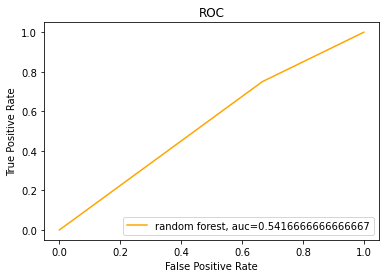

In [17]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2020-01-01','2020-03-30',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)
from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)

auc_roc(y_test_RF, y_pre_RF)

[2 3 6 7 8]


[I 2023-03-08 09:57:36,308] A new study created in memory with name: no-name-780aa1c5-2262-4c19-b297-5c2948596b78


              precision    recall  f1-score   support

           0       0.51      0.67      0.58        45
           1       0.50      0.34      0.41        44

    accuracy                           0.51        89
   macro avg       0.50      0.50      0.49        89
weighted avg       0.50      0.51      0.49        89

RandomForestClassifier


[I 2023-03-08 09:57:36,928] Trial 0 finished with value: 0.4943820224719101 and parameters: {'n_estimators': 447, 'min_samoles_leaf': 12}. Best is trial 0 with value: 0.4943820224719101.
[I 2023-03-08 09:57:38,383] Trial 1 finished with value: 0.5168539325842697 and parameters: {'n_estimators': 1040, 'min_samoles_leaf': 7}. Best is trial 1 with value: 0.5168539325842697.
[I 2023-03-08 09:57:38,649] Trial 2 finished with value: 0.5393258426966292 and parameters: {'n_estimators': 192, 'min_samoles_leaf': 14}. Best is trial 2 with value: 0.5393258426966292.
[I 2023-03-08 09:57:40,383] Trial 3 finished with value: 0.4943820224719101 and parameters: {'n_estimators': 1205, 'min_samoles_leaf': 5}. Best is trial 2 with value: 0.5393258426966292.
[I 2023-03-08 09:57:42,089] Trial 4 finished with value: 0.550561797752809 and parameters: {'n_estimators': 1252, 'min_samoles_leaf': 14}. Best is trial 4 with value: 0.550561797752809.
[I 2023-03-08 09:57:43,766] Trial 5 finished with value: 0.6179775

[I 2023-03-08 09:58:45,901] Trial 41 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 1100, 'min_samoles_leaf': 15}. Best is trial 5 with value: 0.6179775280898876.
[I 2023-03-08 09:58:47,157] Trial 42 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 912, 'min_samoles_leaf': 15}. Best is trial 5 with value: 0.6179775280898876.
[I 2023-03-08 09:58:48,797] Trial 43 finished with value: 0.550561797752809 and parameters: {'n_estimators': 1194, 'min_samoles_leaf': 14}. Best is trial 5 with value: 0.6179775280898876.
[I 2023-03-08 09:58:50,924] Trial 44 finished with value: 0.5168539325842697 and parameters: {'n_estimators': 1541, 'min_samoles_leaf': 13}. Best is trial 5 with value: 0.6179775280898876.
[I 2023-03-08 09:58:51,905] Trial 45 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 707, 'min_samoles_leaf': 15}. Best is trial 5 with value: 0.6179775280898876.
[I 2023-03-08 09:58:54,619] Trial 46 finished with value: 

[I 2023-03-08 10:00:04,395] Trial 82 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 1543, 'min_samoles_leaf': 15}. Best is trial 5 with value: 0.6179775280898876.
[I 2023-03-08 10:00:06,721] Trial 83 finished with value: 0.550561797752809 and parameters: {'n_estimators': 1697, 'min_samoles_leaf': 14}. Best is trial 5 with value: 0.6179775280898876.
[I 2023-03-08 10:00:09,123] Trial 84 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 1752, 'min_samoles_leaf': 15}. Best is trial 5 with value: 0.6179775280898876.
[I 2023-03-08 10:00:10,881] Trial 85 finished with value: 0.550561797752809 and parameters: {'n_estimators': 1279, 'min_samoles_leaf': 14}. Best is trial 5 with value: 0.6179775280898876.
[I 2023-03-08 10:00:12,841] Trial 86 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 1423, 'min_samoles_leaf': 15}. Best is trial 5 with value: 0.6179775280898876.
[I 2023-03-08 10:00:14,368] Trial 87 finished with value:

準確度： 0.6179775280898876
最佳參數 {'n_estimators': 1232, 'min_samoles_leaf': 15}
auc =  0.5037878787878788
accuracy: 0.5056179775280899


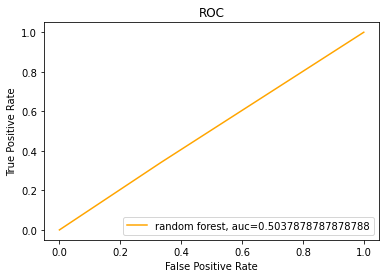

In [18]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2020-03-20','2021-12-31',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)

from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)

auc_roc(y_test_RF, y_pre_RF)

[ 0  1 10 11 14]
              precision    recall  f1-score   support

           0       0.25      0.15      0.19        13
           1       0.50      0.65      0.56        17

    accuracy                           0.43        30
   macro avg       0.38      0.40      0.38        30
weighted avg       0.39      0.43      0.40        30

RandomForestClassifier
auc =  0.4004524886877828
accuracy: 0.43333333333333335


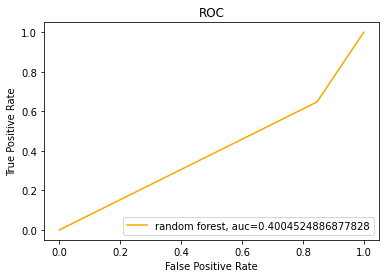

[I 2023-03-08 10:00:37,614] A new study created in memory with name: no-name-6be66e37-ac11-44d1-8513-b863e672f939
[I 2023-03-08 10:00:39,222] Trial 0 finished with value: 0.43333333333333335 and parameters: {'n_estimators': 1235, 'min_samoles_leaf': 10}. Best is trial 0 with value: 0.43333333333333335.
[I 2023-03-08 10:00:40,321] Trial 1 finished with value: 0.43333333333333335 and parameters: {'n_estimators': 841, 'min_samoles_leaf': 10}. Best is trial 0 with value: 0.43333333333333335.
[I 2023-03-08 10:00:42,572] Trial 2 finished with value: 0.43333333333333335 and parameters: {'n_estimators': 1719, 'min_samoles_leaf': 9}. Best is trial 0 with value: 0.43333333333333335.
[I 2023-03-08 10:00:45,035] Trial 3 finished with value: 0.43333333333333335 and parameters: {'n_estimators': 1879, 'min_samoles_leaf': 10}. Best is trial 0 with value: 0.43333333333333335.
[I 2023-03-08 10:00:47,296] Trial 4 finished with value: 0.43333333333333335 and parameters: {'n_estimators': 1678, 'min_samoles

[I 2023-03-08 10:01:30,361] Trial 41 finished with value: 0.4666666666666667 and parameters: {'n_estimators': 1004, 'min_samoles_leaf': 14}. Best is trial 39 with value: 0.5.
[I 2023-03-08 10:01:31,522] Trial 42 finished with value: 0.4666666666666667 and parameters: {'n_estimators': 904, 'min_samoles_leaf': 15}. Best is trial 39 with value: 0.5.
[I 2023-03-08 10:01:33,060] Trial 43 finished with value: 0.4666666666666667 and parameters: {'n_estimators': 1193, 'min_samoles_leaf': 14}. Best is trial 39 with value: 0.5.
[I 2023-03-08 10:01:33,865] Trial 44 finished with value: 0.43333333333333335 and parameters: {'n_estimators': 614, 'min_samoles_leaf': 13}. Best is trial 39 with value: 0.5.
[I 2023-03-08 10:01:35,724] Trial 45 finished with value: 0.4666666666666667 and parameters: {'n_estimators': 1455, 'min_samoles_leaf': 15}. Best is trial 39 with value: 0.5.
[I 2023-03-08 10:01:36,703] Trial 46 finished with value: 0.43333333333333335 and parameters: {'n_estimators': 744, 'min_samol

[I 2023-03-08 10:02:16,883] Trial 86 finished with value: 0.43333333333333335 and parameters: {'n_estimators': 640, 'min_samoles_leaf': 13}. Best is trial 39 with value: 0.5.
[I 2023-03-08 10:02:17,260] Trial 87 finished with value: 0.43333333333333335 and parameters: {'n_estimators': 278, 'min_samoles_leaf': 15}. Best is trial 39 with value: 0.5.
[I 2023-03-08 10:02:18,440] Trial 88 finished with value: 0.4 and parameters: {'n_estimators': 882, 'min_samoles_leaf': 7}. Best is trial 39 with value: 0.5.
[I 2023-03-08 10:02:19,388] Trial 89 finished with value: 0.4666666666666667 and parameters: {'n_estimators': 726, 'min_samoles_leaf': 14}. Best is trial 39 with value: 0.5.
[I 2023-03-08 10:02:20,129] Trial 90 finished with value: 0.4666666666666667 and parameters: {'n_estimators': 565, 'min_samoles_leaf': 15}. Best is trial 39 with value: 0.5.
[I 2023-03-08 10:02:20,784] Trial 91 finished with value: 0.5 and parameters: {'n_estimators': 499, 'min_samoles_leaf': 15}. Best is trial 39 wi

準確度： 0.5
最佳參數 {'n_estimators': 892, 'min_samoles_leaf': 14}


In [19]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2008-06-01','2008-12-31',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)

auc_roc(y_test_RF, y_pre_RF)

from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)


[2 3 6 7 8]
              precision    recall  f1-score   support

           0       0.68      0.82      0.74        28
           1       0.71      0.52      0.60        23

    accuracy                           0.69        51
   macro avg       0.69      0.67      0.67        51
weighted avg       0.69      0.69      0.68        51

RandomForestClassifier
auc =  0.671583850931677
accuracy: 0.6862745098039216


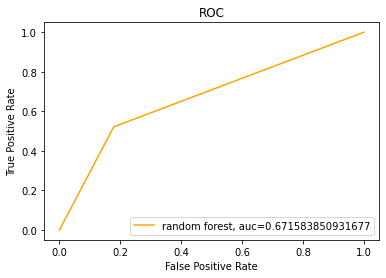

[I 2023-03-08 10:02:29,477] A new study created in memory with name: no-name-07204132-35e1-419f-8be6-9e4f4499a372
[I 2023-03-08 10:02:31,057] Trial 0 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 1140, 'min_samoles_leaf': 5}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-03-08 10:02:31,639] Trial 1 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 426, 'min_samoles_leaf': 9}. Best is trial 1 with value: 0.7058823529411765.
[I 2023-03-08 10:02:33,509] Trial 2 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 1409, 'min_samoles_leaf': 13}. Best is trial 1 with value: 0.7058823529411765.
[I 2023-03-08 10:02:34,689] Trial 3 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 891, 'min_samoles_leaf': 14}. Best is trial 1 with value: 0.7058823529411765.
[I 2023-03-08 10:02:34,945] Trial 4 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 188, 'min_samoles_leaf': 12}.

[I 2023-03-08 10:03:07,583] Trial 41 finished with value: 0.6862745098039216 and parameters: {'n_estimators': 505, 'min_samoles_leaf': 9}. Best is trial 32 with value: 0.7254901960784313.
[I 2023-03-08 10:03:08,558] Trial 42 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 710, 'min_samoles_leaf': 9}. Best is trial 32 with value: 0.7254901960784313.
[I 2023-03-08 10:03:08,838] Trial 43 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 195, 'min_samoles_leaf': 10}. Best is trial 32 with value: 0.7254901960784313.
[I 2023-03-08 10:03:09,447] Trial 44 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 438, 'min_samoles_leaf': 8}. Best is trial 32 with value: 0.7254901960784313.
[I 2023-03-08 10:03:10,249] Trial 45 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 582, 'min_samoles_leaf': 9}. Best is trial 32 with value: 0.7254901960784313.
[I 2023-03-08 10:03:11,577] Trial 46 finished with value: 0

[I 2023-03-08 10:03:44,220] Trial 82 finished with value: 0.6862745098039216 and parameters: {'n_estimators': 495, 'min_samoles_leaf': 10}. Best is trial 32 with value: 0.7254901960784313.
[I 2023-03-08 10:03:45,023] Trial 83 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 581, 'min_samoles_leaf': 8}. Best is trial 32 with value: 0.7254901960784313.
[I 2023-03-08 10:03:45,600] Trial 84 finished with value: 0.6862745098039216 and parameters: {'n_estimators': 408, 'min_samoles_leaf': 9}. Best is trial 32 with value: 0.7254901960784313.
[I 2023-03-08 10:03:46,472] Trial 85 finished with value: 0.6274509803921569 and parameters: {'n_estimators': 630, 'min_samoles_leaf': 7}. Best is trial 32 with value: 0.7254901960784313.
[I 2023-03-08 10:03:46,956] Trial 86 finished with value: 0.6862745098039216 and parameters: {'n_estimators': 341, 'min_samoles_leaf': 8}. Best is trial 32 with value: 0.7254901960784313.
[I 2023-03-08 10:03:47,595] Trial 87 finished with value: 0

準確度： 0.7254901960784313
最佳參數 {'n_estimators': 132, 'min_samoles_leaf': 8}


In [20]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2009-01-01','2009-12-31',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)

auc_roc(y_test_RF, y_pre_RF)

from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)


[10 11 12 13 16]
              precision    recall  f1-score   support

           0       0.66      0.58      0.61        33
           1       0.36      0.44      0.40        18

    accuracy                           0.53        51
   macro avg       0.51      0.51      0.51        51
weighted avg       0.55      0.53      0.54        51

RandomForestClassifier
auc =  0.51010101010101
accuracy: 0.5294117647058824


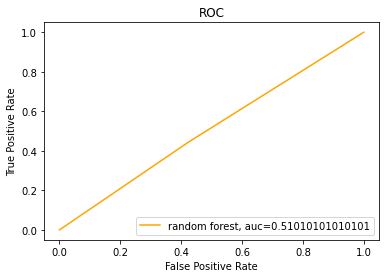

[I 2023-03-08 10:04:01,627] A new study created in memory with name: no-name-0f136386-14a6-42cf-9427-761f381ec0d1
[I 2023-03-08 10:04:03,532] Trial 0 finished with value: 0.5490196078431373 and parameters: {'n_estimators': 1395, 'min_samoles_leaf': 10}. Best is trial 0 with value: 0.5490196078431373.
[I 2023-03-08 10:04:06,058] Trial 1 finished with value: 0.5098039215686274 and parameters: {'n_estimators': 1864, 'min_samoles_leaf': 5}. Best is trial 0 with value: 0.5490196078431373.
[I 2023-03-08 10:04:06,877] Trial 2 finished with value: 0.6078431372549019 and parameters: {'n_estimators': 619, 'min_samoles_leaf': 13}. Best is trial 2 with value: 0.6078431372549019.
[I 2023-03-08 10:04:07,424] Trial 3 finished with value: 0.5098039215686274 and parameters: {'n_estimators': 396, 'min_samoles_leaf': 6}. Best is trial 2 with value: 0.6078431372549019.
[I 2023-03-08 10:04:08,485] Trial 4 finished with value: 0.5686274509803921 and parameters: {'n_estimators': 783, 'min_samoles_leaf': 8}. 

[I 2023-03-08 10:05:10,010] Trial 41 finished with value: 0.6470588235294118 and parameters: {'n_estimators': 1594, 'min_samoles_leaf': 15}. Best is trial 7 with value: 0.6470588235294118.
[I 2023-03-08 10:05:12,506] Trial 42 finished with value: 0.6274509803921569 and parameters: {'n_estimators': 1886, 'min_samoles_leaf': 14}. Best is trial 7 with value: 0.6470588235294118.
[I 2023-03-08 10:05:14,811] Trial 43 finished with value: 0.6470588235294118 and parameters: {'n_estimators': 1731, 'min_samoles_leaf': 15}. Best is trial 7 with value: 0.6470588235294118.
[I 2023-03-08 10:05:16,737] Trial 44 finished with value: 0.6470588235294118 and parameters: {'n_estimators': 1448, 'min_samoles_leaf': 14}. Best is trial 7 with value: 0.6470588235294118.
[I 2023-03-08 10:05:18,187] Trial 45 finished with value: 0.5882352941176471 and parameters: {'n_estimators': 1084, 'min_samoles_leaf': 13}. Best is trial 7 with value: 0.6470588235294118.
[I 2023-03-08 10:05:20,708] Trial 46 finished with valu

[I 2023-03-08 10:08:05,756] Trial 82 finished with value: 0.6470588235294118 and parameters: {'n_estimators': 883, 'min_samoles_leaf': 15}. Best is trial 7 with value: 0.6470588235294118.
[I 2023-03-08 10:08:07,182] Trial 83 finished with value: 0.5294117647058824 and parameters: {'n_estimators': 1050, 'min_samoles_leaf': 10}. Best is trial 7 with value: 0.6470588235294118.
[I 2023-03-08 10:08:08,243] Trial 84 finished with value: 0.6470588235294118 and parameters: {'n_estimators': 784, 'min_samoles_leaf': 14}. Best is trial 7 with value: 0.6470588235294118.
[I 2023-03-08 10:08:10,612] Trial 85 finished with value: 0.6470588235294118 and parameters: {'n_estimators': 1766, 'min_samoles_leaf': 15}. Best is trial 7 with value: 0.6470588235294118.
[I 2023-03-08 10:08:12,423] Trial 86 finished with value: 0.6470588235294118 and parameters: {'n_estimators': 1357, 'min_samoles_leaf': 14}. Best is trial 7 with value: 0.6470588235294118.
[I 2023-03-08 10:08:13,670] Trial 87 finished with value:

準確度： 0.6470588235294118
最佳參數 {'n_estimators': 1085, 'min_samoles_leaf': 14}


In [21]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2010-01-01','2010-12-31',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)

auc_roc(y_test_RF, y_pre_RF)

from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)


[ 4  5  8  9 14]
              precision    recall  f1-score   support

           0       0.35      0.42      0.38        19
           1       0.59      0.52      0.55        31

    accuracy                           0.48        50
   macro avg       0.47      0.47      0.47        50
weighted avg       0.50      0.48      0.49        50

RandomForestClassifier
auc =  0.4685908319185059
accuracy: 0.48


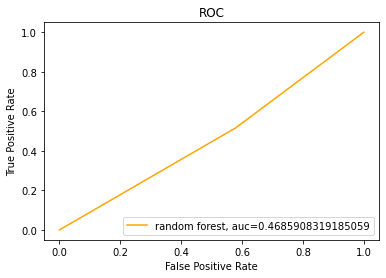

[I 2023-03-08 10:08:34,469] A new study created in memory with name: no-name-7643dd8d-74b1-4968-9be1-9816d9e1e89c
[I 2023-03-08 10:08:35,233] Trial 0 finished with value: 0.44 and parameters: {'n_estimators': 565, 'min_samoles_leaf': 12}. Best is trial 0 with value: 0.44.
[I 2023-03-08 10:08:36,596] Trial 1 finished with value: 0.48 and parameters: {'n_estimators': 988, 'min_samoles_leaf': 5}. Best is trial 1 with value: 0.48.
[I 2023-03-08 10:08:37,129] Trial 2 finished with value: 0.42 and parameters: {'n_estimators': 396, 'min_samoles_leaf': 15}. Best is trial 1 with value: 0.48.
[I 2023-03-08 10:08:38,091] Trial 3 finished with value: 0.4 and parameters: {'n_estimators': 721, 'min_samoles_leaf': 14}. Best is trial 1 with value: 0.48.
[I 2023-03-08 10:08:38,822] Trial 4 finished with value: 0.42 and parameters: {'n_estimators': 551, 'min_samoles_leaf': 13}. Best is trial 1 with value: 0.48.
[I 2023-03-08 10:08:40,800] Trial 5 finished with value: 0.4 and parameters: {'n_estimators':

[I 2023-03-08 10:09:48,202] Trial 47 finished with value: 0.44 and parameters: {'n_estimators': 583, 'min_samoles_leaf': 8}. Best is trial 13 with value: 0.5.
[I 2023-03-08 10:09:50,026] Trial 48 finished with value: 0.48 and parameters: {'n_estimators': 1314, 'min_samoles_leaf': 5}. Best is trial 13 with value: 0.5.
[I 2023-03-08 10:09:51,117] Trial 49 finished with value: 0.4 and parameters: {'n_estimators': 804, 'min_samoles_leaf': 14}. Best is trial 13 with value: 0.5.
[I 2023-03-08 10:09:51,572] Trial 50 finished with value: 0.44 and parameters: {'n_estimators': 326, 'min_samoles_leaf': 11}. Best is trial 13 with value: 0.5.
[I 2023-03-08 10:09:53,202] Trial 51 finished with value: 0.5 and parameters: {'n_estimators': 1192, 'min_samoles_leaf': 7}. Best is trial 13 with value: 0.5.
[I 2023-03-08 10:09:54,809] Trial 52 finished with value: 0.5 and parameters: {'n_estimators': 1163, 'min_samoles_leaf': 7}. Best is trial 13 with value: 0.5.
[I 2023-03-08 10:09:56,253] Trial 53 finishe

[I 2023-03-08 10:11:05,785] Trial 95 finished with value: 0.5 and parameters: {'n_estimators': 1182, 'min_samoles_leaf': 7}. Best is trial 13 with value: 0.5.
[I 2023-03-08 10:11:06,651] Trial 96 finished with value: 0.46 and parameters: {'n_estimators': 626, 'min_samoles_leaf': 8}. Best is trial 13 with value: 0.5.
[I 2023-03-08 10:11:08,642] Trial 97 finished with value: 0.5 and parameters: {'n_estimators': 1455, 'min_samoles_leaf': 7}. Best is trial 13 with value: 0.5.
[I 2023-03-08 10:11:10,200] Trial 98 finished with value: 0.42 and parameters: {'n_estimators': 1147, 'min_samoles_leaf': 11}. Best is trial 13 with value: 0.5.
[I 2023-03-08 10:11:11,902] Trial 99 finished with value: 0.5 and parameters: {'n_estimators': 1208, 'min_samoles_leaf': 6}. Best is trial 13 with value: 0.5.


準確度： 0.5
最佳參數 {'n_estimators': 1211, 'min_samoles_leaf': 7}


In [22]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2011-01-01','2011-12-31',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)

auc_roc(y_test_RF, y_pre_RF)

from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)


[3 4 7 8 9]
              precision    recall  f1-score   support

           0       0.52      0.46      0.49        26
           1       0.48      0.54      0.51        24

    accuracy                           0.50        50
   macro avg       0.50      0.50      0.50        50
weighted avg       0.50      0.50      0.50        50

RandomForestClassifier
auc =  0.5016025641025641
accuracy: 0.5


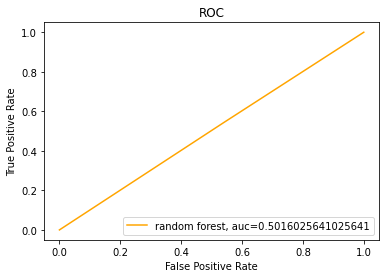

[I 2023-03-08 10:11:14,784] A new study created in memory with name: no-name-c6afa89e-25c6-43b7-9ff1-dcd9d389ec79
[I 2023-03-08 10:11:16,416] Trial 0 finished with value: 0.42 and parameters: {'n_estimators': 1171, 'min_samoles_leaf': 12}. Best is trial 0 with value: 0.42.
[I 2023-03-08 10:11:17,612] Trial 1 finished with value: 0.46 and parameters: {'n_estimators': 885, 'min_samoles_leaf': 11}. Best is trial 1 with value: 0.46.
[I 2023-03-08 10:11:18,191] Trial 2 finished with value: 0.48 and parameters: {'n_estimators': 416, 'min_samoles_leaf': 6}. Best is trial 2 with value: 0.48.
[I 2023-03-08 10:11:20,555] Trial 3 finished with value: 0.42 and parameters: {'n_estimators': 1753, 'min_samoles_leaf': 12}. Best is trial 2 with value: 0.48.
[I 2023-03-08 10:11:22,446] Trial 4 finished with value: 0.48 and parameters: {'n_estimators': 1374, 'min_samoles_leaf': 8}. Best is trial 2 with value: 0.48.
[I 2023-03-08 10:11:24,589] Trial 5 finished with value: 0.48 and parameters: {'n_estimato

[I 2023-03-08 10:12:56,972] Trial 47 finished with value: 0.5 and parameters: {'n_estimators': 1993, 'min_samoles_leaf': 5}. Best is trial 12 with value: 0.5.
[I 2023-03-08 10:12:58,035] Trial 48 finished with value: 0.48 and parameters: {'n_estimators': 772, 'min_samoles_leaf': 7}. Best is trial 12 with value: 0.5.
[I 2023-03-08 10:12:59,663] Trial 49 finished with value: 0.48 and parameters: {'n_estimators': 1176, 'min_samoles_leaf': 6}. Best is trial 12 with value: 0.5.
[I 2023-03-08 10:13:00,360] Trial 50 finished with value: 0.46 and parameters: {'n_estimators': 506, 'min_samoles_leaf': 11}. Best is trial 12 with value: 0.5.
[I 2023-03-08 10:13:02,995] Trial 51 finished with value: 0.5 and parameters: {'n_estimators': 1889, 'min_samoles_leaf': 5}. Best is trial 12 with value: 0.5.
[I 2023-03-08 10:13:05,056] Trial 52 finished with value: 0.4 and parameters: {'n_estimators': 1548, 'min_samoles_leaf': 13}. Best is trial 12 with value: 0.5.
[I 2023-03-08 10:13:07,493] Trial 53 finish

[I 2023-03-08 10:14:45,687] Trial 95 finished with value: 0.42 and parameters: {'n_estimators': 1766, 'min_samoles_leaf': 12}. Best is trial 12 with value: 0.5.
[I 2023-03-08 10:14:48,380] Trial 96 finished with value: 0.48 and parameters: {'n_estimators': 1966, 'min_samoles_leaf': 6}. Best is trial 12 with value: 0.5.
[I 2023-03-08 10:14:50,948] Trial 97 finished with value: 0.5 and parameters: {'n_estimators': 1859, 'min_samoles_leaf': 5}. Best is trial 12 with value: 0.5.
[I 2023-03-08 10:14:53,650] Trial 98 finished with value: 0.5 and parameters: {'n_estimators': 1935, 'min_samoles_leaf': 5}. Best is trial 12 with value: 0.5.
[I 2023-03-08 10:14:56,016] Trial 99 finished with value: 0.5 and parameters: {'n_estimators': 1695, 'min_samoles_leaf': 5}. Best is trial 12 with value: 0.5.


準確度： 0.5
最佳參數 {'n_estimators': 1933, 'min_samoles_leaf': 5}


In [23]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2012-01-01','2012-12-31',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)

auc_roc(y_test_RF, y_pre_RF)

from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)


[3 4 7 8 9]
              precision    recall  f1-score   support

           0       0.36      0.32      0.34        25
           1       0.39      0.44      0.42        25

    accuracy                           0.38        50
   macro avg       0.38      0.38      0.38        50
weighted avg       0.38      0.38      0.38        50

RandomForestClassifier
auc =  0.38
accuracy: 0.38


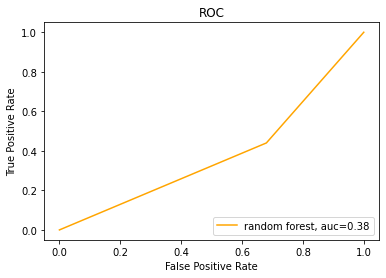

[I 2023-03-08 10:14:58,886] A new study created in memory with name: no-name-0eeba460-0411-426e-bd46-e799d2686c8e
[I 2023-03-08 10:15:00,556] Trial 0 finished with value: 0.48 and parameters: {'n_estimators': 1262, 'min_samoles_leaf': 14}. Best is trial 0 with value: 0.48.
[I 2023-03-08 10:15:02,526] Trial 1 finished with value: 0.36 and parameters: {'n_estimators': 1422, 'min_samoles_leaf': 5}. Best is trial 0 with value: 0.48.
[I 2023-03-08 10:15:03,520] Trial 2 finished with value: 0.4 and parameters: {'n_estimators': 723, 'min_samoles_leaf': 11}. Best is trial 0 with value: 0.48.
[I 2023-03-08 10:15:05,612] Trial 3 finished with value: 0.42 and parameters: {'n_estimators': 1528, 'min_samoles_leaf': 6}. Best is trial 0 with value: 0.48.
[I 2023-03-08 10:15:06,387] Trial 4 finished with value: 0.44 and parameters: {'n_estimators': 574, 'min_samoles_leaf': 12}. Best is trial 0 with value: 0.48.
[I 2023-03-08 10:15:08,581] Trial 5 finished with value: 0.42 and parameters: {'n_estimator

[I 2023-03-08 10:16:25,880] Trial 47 finished with value: 0.44 and parameters: {'n_estimators': 1617, 'min_samoles_leaf': 12}. Best is trial 42 with value: 0.52.
[I 2023-03-08 10:16:28,217] Trial 48 finished with value: 0.46 and parameters: {'n_estimators': 1750, 'min_samoles_leaf': 13}. Best is trial 42 with value: 0.52.
[I 2023-03-08 10:16:30,408] Trial 49 finished with value: 0.48 and parameters: {'n_estimators': 1637, 'min_samoles_leaf': 13}. Best is trial 42 with value: 0.52.
[I 2023-03-08 10:16:32,285] Trial 50 finished with value: 0.46 and parameters: {'n_estimators': 1403, 'min_samoles_leaf': 14}. Best is trial 42 with value: 0.52.
[I 2023-03-08 10:16:34,789] Trial 51 finished with value: 0.5 and parameters: {'n_estimators': 1877, 'min_samoles_leaf': 14}. Best is trial 42 with value: 0.52.
[I 2023-03-08 10:16:37,176] Trial 52 finished with value: 0.52 and parameters: {'n_estimators': 1788, 'min_samoles_leaf': 14}. Best is trial 42 with value: 0.52.
[I 2023-03-08 10:16:39,704] T

[I 2023-03-08 10:18:18,660] Trial 94 finished with value: 0.48 and parameters: {'n_estimators': 1731, 'min_samoles_leaf': 13}. Best is trial 42 with value: 0.52.
[I 2023-03-08 10:18:21,273] Trial 95 finished with value: 0.48 and parameters: {'n_estimators': 1898, 'min_samoles_leaf': 15}. Best is trial 42 with value: 0.52.
[I 2023-03-08 10:18:23,742] Trial 96 finished with value: 0.44 and parameters: {'n_estimators': 1792, 'min_samoles_leaf': 12}. Best is trial 42 with value: 0.52.
[I 2023-03-08 10:18:26,454] Trial 97 finished with value: 0.38 and parameters: {'n_estimators': 1976, 'min_samoles_leaf': 10}. Best is trial 42 with value: 0.52.
[I 2023-03-08 10:18:28,904] Trial 98 finished with value: 0.5 and parameters: {'n_estimators': 1843, 'min_samoles_leaf': 14}. Best is trial 42 with value: 0.52.
[I 2023-03-08 10:18:29,554] Trial 99 finished with value: 0.48 and parameters: {'n_estimators': 456, 'min_samoles_leaf': 13}. Best is trial 42 with value: 0.52.


準確度： 0.52
最佳參數 {'n_estimators': 1705, 'min_samoles_leaf': 14}


In [24]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2013-01-01','2013-12-31',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)

auc_roc(y_test_RF, y_pre_RF)

from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)


[2 6 7 8 9]
              precision    recall  f1-score   support

           0       0.59      0.59      0.59        29
           1       0.43      0.43      0.43        21

    accuracy                           0.52        50
   macro avg       0.51      0.51      0.51        50
weighted avg       0.52      0.52      0.52        50

RandomForestClassifier
auc =  0.5073891625615764
accuracy: 0.52


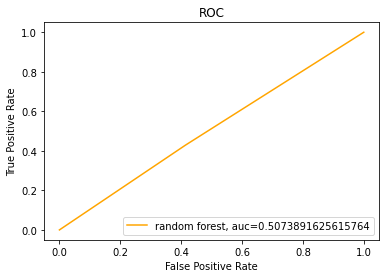

[I 2023-03-08 10:18:32,486] A new study created in memory with name: no-name-4f530ea7-78ca-45c6-90d7-fa3fb4e7454c
[I 2023-03-08 10:18:34,543] Trial 0 finished with value: 0.52 and parameters: {'n_estimators': 1482, 'min_samoles_leaf': 12}. Best is trial 0 with value: 0.52.
[I 2023-03-08 10:18:35,629] Trial 1 finished with value: 0.56 and parameters: {'n_estimators': 791, 'min_samoles_leaf': 8}. Best is trial 1 with value: 0.56.
[I 2023-03-08 10:18:36,070] Trial 2 finished with value: 0.56 and parameters: {'n_estimators': 311, 'min_samoles_leaf': 5}. Best is trial 1 with value: 0.56.
[I 2023-03-08 10:18:37,157] Trial 3 finished with value: 0.5 and parameters: {'n_estimators': 818, 'min_samoles_leaf': 14}. Best is trial 1 with value: 0.56.
[I 2023-03-08 10:18:37,786] Trial 4 finished with value: 0.52 and parameters: {'n_estimators': 474, 'min_samoles_leaf': 14}. Best is trial 1 with value: 0.56.
[I 2023-03-08 10:18:38,364] Trial 5 finished with value: 0.52 and parameters: {'n_estimators'

[I 2023-03-08 10:19:31,745] Trial 47 finished with value: 0.56 and parameters: {'n_estimators': 621, 'min_samoles_leaf': 8}. Best is trial 12 with value: 0.58.
[I 2023-03-08 10:19:32,838] Trial 48 finished with value: 0.54 and parameters: {'n_estimators': 774, 'min_samoles_leaf': 6}. Best is trial 12 with value: 0.58.
[I 2023-03-08 10:19:33,275] Trial 49 finished with value: 0.56 and parameters: {'n_estimators': 309, 'min_samoles_leaf': 7}. Best is trial 12 with value: 0.58.
[I 2023-03-08 10:19:34,827] Trial 50 finished with value: 0.5 and parameters: {'n_estimators': 1151, 'min_samoles_leaf': 13}. Best is trial 12 with value: 0.58.
[I 2023-03-08 10:19:36,287] Trial 51 finished with value: 0.56 and parameters: {'n_estimators': 1036, 'min_samoles_leaf': 8}. Best is trial 12 with value: 0.58.
[I 2023-03-08 10:19:38,194] Trial 52 finished with value: 0.54 and parameters: {'n_estimators': 1350, 'min_samoles_leaf': 9}. Best is trial 12 with value: 0.58.
[I 2023-03-08 10:19:38,453] Trial 53 

[I 2023-03-08 10:20:17,515] Trial 95 finished with value: 0.56 and parameters: {'n_estimators': 1024, 'min_samoles_leaf': 8}. Best is trial 12 with value: 0.58.
[I 2023-03-08 10:20:17,788] Trial 96 finished with value: 0.54 and parameters: {'n_estimators': 174, 'min_samoles_leaf': 7}. Best is trial 12 with value: 0.58.
[I 2023-03-08 10:20:18,225] Trial 97 finished with value: 0.5 and parameters: {'n_estimators': 300, 'min_samoles_leaf': 15}. Best is trial 12 with value: 0.58.
[I 2023-03-08 10:20:20,206] Trial 98 finished with value: 0.56 and parameters: {'n_estimators': 1421, 'min_samoles_leaf': 8}. Best is trial 12 with value: 0.58.
[I 2023-03-08 10:20:21,247] Trial 99 finished with value: 0.54 and parameters: {'n_estimators': 747, 'min_samoles_leaf': 9}. Best is trial 12 with value: 0.58.


準確度： 0.58
最佳參數 {'n_estimators': 118, 'min_samoles_leaf': 7}


In [25]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2014-01-01','2014-12-31',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)

auc_roc(y_test_RF, y_pre_RF)

from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)


[0 4 5 8 9]
              precision    recall  f1-score   support

           0       0.59      0.37      0.45        27
           1       0.47      0.68      0.56        22

    accuracy                           0.51        49
   macro avg       0.53      0.53      0.51        49
weighted avg       0.53      0.51      0.50        49

RandomForestClassifier
auc =  0.5260942760942761
accuracy: 0.5102040816326531


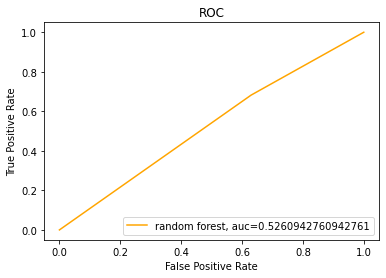

[I 2023-03-08 10:20:24,117] A new study created in memory with name: no-name-51efab9b-70dc-4b45-823f-91d86a4c0cdd
[I 2023-03-08 10:20:24,909] Trial 0 finished with value: 0.4897959183673469 and parameters: {'n_estimators': 566, 'min_samoles_leaf': 14}. Best is trial 0 with value: 0.4897959183673469.
[I 2023-03-08 10:20:26,891] Trial 1 finished with value: 0.46938775510204084 and parameters: {'n_estimators': 1450, 'min_samoles_leaf': 13}. Best is trial 0 with value: 0.4897959183673469.
[I 2023-03-08 10:20:29,524] Trial 2 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 1955, 'min_samoles_leaf': 11}. Best is trial 2 with value: 0.5102040816326531.
[I 2023-03-08 10:20:30,550] Trial 3 finished with value: 0.4897959183673469 and parameters: {'n_estimators': 753, 'min_samoles_leaf': 9}. Best is trial 2 with value: 0.5102040816326531.
[I 2023-03-08 10:20:30,978] Trial 4 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 289, 'min_samoles_leaf': 5}

[I 2023-03-08 10:21:28,259] Trial 41 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 215, 'min_samoles_leaf': 5}. Best is trial 2 with value: 0.5102040816326531.
[I 2023-03-08 10:21:28,416] Trial 42 finished with value: 0.4897959183673469 and parameters: {'n_estimators': 100, 'min_samoles_leaf': 6}. Best is trial 2 with value: 0.5102040816326531.
[I 2023-03-08 10:21:28,780] Trial 43 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 227, 'min_samoles_leaf': 5}. Best is trial 2 with value: 0.5102040816326531.
[I 2023-03-08 10:21:29,265] Trial 44 finished with value: 0.4897959183673469 and parameters: {'n_estimators': 347, 'min_samoles_leaf': 12}. Best is trial 2 with value: 0.5102040816326531.
[I 2023-03-08 10:21:29,865] Trial 45 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 429, 'min_samoles_leaf': 6}. Best is trial 2 with value: 0.5102040816326531.
[I 2023-03-08 10:21:31,294] Trial 46 finished with value: 0.4897

[I 2023-03-08 10:22:05,116] Trial 82 finished with value: 0.4897959183673469 and parameters: {'n_estimators': 1103, 'min_samoles_leaf': 6}. Best is trial 2 with value: 0.5102040816326531.
[I 2023-03-08 10:22:05,431] Trial 83 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 209, 'min_samoles_leaf': 5}. Best is trial 2 with value: 0.5102040816326531.
[I 2023-03-08 10:22:06,533] Trial 84 finished with value: 0.4897959183673469 and parameters: {'n_estimators': 793, 'min_samoles_leaf': 6}. Best is trial 2 with value: 0.5102040816326531.
[I 2023-03-08 10:22:08,282] Trial 85 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 1270, 'min_samoles_leaf': 10}. Best is trial 2 with value: 0.5102040816326531.
[I 2023-03-08 10:22:09,627] Trial 86 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 935, 'min_samoles_leaf': 5}. Best is trial 2 with value: 0.5102040816326531.
[I 2023-03-08 10:22:10,429] Trial 87 finished with value: 0.48

準確度： 0.5102040816326531
最佳參數 {'n_estimators': 1955, 'min_samoles_leaf': 11}


In [26]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2015-01-01','2015-12-31',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)

auc_roc(y_test_RF, y_pre_RF)
from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)


[ 0  4 12 13 14]
              precision    recall  f1-score   support

           0       0.61      0.55      0.58        31
           1       0.33      0.39      0.36        18

    accuracy                           0.49        49
   macro avg       0.47      0.47      0.47        49
weighted avg       0.51      0.49      0.50        49

RandomForestClassifier
auc =  0.4686379928315412
accuracy: 0.4897959183673469


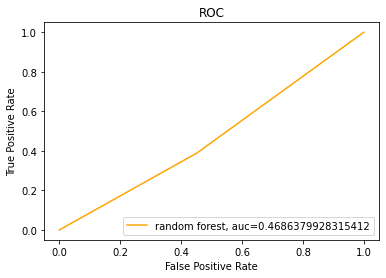

[I 2023-03-08 10:22:24,767] A new study created in memory with name: no-name-69c0342e-b1b7-4491-b18e-3b8f83a8fb8d
[I 2023-03-08 10:22:26,682] Trial 0 finished with value: 0.4897959183673469 and parameters: {'n_estimators': 1402, 'min_samoles_leaf': 9}. Best is trial 0 with value: 0.4897959183673469.
[I 2023-03-08 10:22:28,845] Trial 1 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 1571, 'min_samoles_leaf': 7}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:22:29,868] Trial 2 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 763, 'min_samoles_leaf': 13}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:22:30,056] Trial 3 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 128, 'min_samoles_leaf': 6}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:22:31,289] Trial 4 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 879, 'min_samoles_leaf': 14}. 

[I 2023-03-08 10:23:22,865] Trial 41 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 957, 'min_samoles_leaf': 14}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:23:24,289] Trial 42 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 1067, 'min_samoles_leaf': 13}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:23:24,983] Trial 43 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 504, 'min_samoles_leaf': 12}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:23:25,883] Trial 44 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 662, 'min_samoles_leaf': 14}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:23:27,199] Trial 45 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 928, 'min_samoles_leaf': 7}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:23:28,299] Trial 46 finished with value: 0.

[I 2023-03-08 10:24:28,585] Trial 82 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 932, 'min_samoles_leaf': 7}. Best is trial 74 with value: 0.5306122448979592.
[I 2023-03-08 10:24:30,729] Trial 83 finished with value: 0.4897959183673469 and parameters: {'n_estimators': 1559, 'min_samoles_leaf': 9}. Best is trial 74 with value: 0.5306122448979592.
[I 2023-03-08 10:24:31,804] Trial 84 finished with value: 0.4897959183673469 and parameters: {'n_estimators': 772, 'min_samoles_leaf': 9}. Best is trial 74 with value: 0.5306122448979592.
[I 2023-03-08 10:24:34,162] Trial 85 finished with value: 0.4897959183673469 and parameters: {'n_estimators': 1688, 'min_samoles_leaf': 6}. Best is trial 74 with value: 0.5306122448979592.
[I 2023-03-08 10:24:36,012] Trial 86 finished with value: 0.4897959183673469 and parameters: {'n_estimators': 1348, 'min_samoles_leaf': 8}. Best is trial 74 with value: 0.5306122448979592.
[I 2023-03-08 10:24:37,189] Trial 87 finished with value:

準確度： 0.5306122448979592
最佳參數 {'n_estimators': 1560, 'min_samoles_leaf': 8}


In [27]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2016-01-01','2016-12-31',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)

auc_roc(y_test_RF, y_pre_RF)

from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)


[1 2 6 7 9]
              precision    recall  f1-score   support

           0       0.61      0.69      0.65        29
           1       0.47      0.38      0.42        21

    accuracy                           0.56        50
   macro avg       0.54      0.54      0.53        50
weighted avg       0.55      0.56      0.55        50

RandomForestClassifier
auc =  0.535303776683087
accuracy: 0.56


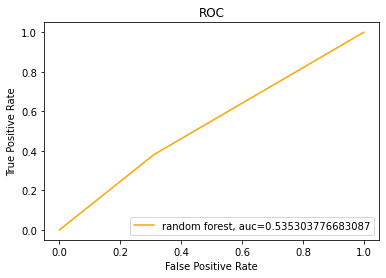

[I 2023-03-08 10:25:02,800] A new study created in memory with name: no-name-f344ef1d-8e52-4262-8937-29b3c736259d
[I 2023-03-08 10:25:03,196] Trial 0 finished with value: 0.58 and parameters: {'n_estimators': 280, 'min_samoles_leaf': 5}. Best is trial 0 with value: 0.58.
[I 2023-03-08 10:25:03,577] Trial 1 finished with value: 0.56 and parameters: {'n_estimators': 280, 'min_samoles_leaf': 12}. Best is trial 0 with value: 0.58.
[I 2023-03-08 10:25:06,141] Trial 2 finished with value: 0.6 and parameters: {'n_estimators': 1894, 'min_samoles_leaf': 8}. Best is trial 2 with value: 0.6.
[I 2023-03-08 10:25:06,712] Trial 3 finished with value: 0.6 and parameters: {'n_estimators': 418, 'min_samoles_leaf': 10}. Best is trial 2 with value: 0.6.
[I 2023-03-08 10:25:08,949] Trial 4 finished with value: 0.58 and parameters: {'n_estimators': 1651, 'min_samoles_leaf': 10}. Best is trial 2 with value: 0.6.
[I 2023-03-08 10:25:09,360] Trial 5 finished with value: 0.56 and parameters: {'n_estimators': 2

[I 2023-03-08 10:26:22,682] Trial 47 finished with value: 0.58 and parameters: {'n_estimators': 1600, 'min_samoles_leaf': 7}. Best is trial 10 with value: 0.64.
[I 2023-03-08 10:26:25,159] Trial 48 finished with value: 0.6 and parameters: {'n_estimators': 1828, 'min_samoles_leaf': 8}. Best is trial 10 with value: 0.64.
[I 2023-03-08 10:26:26,459] Trial 49 finished with value: 0.62 and parameters: {'n_estimators': 950, 'min_samoles_leaf': 8}. Best is trial 10 with value: 0.64.
[I 2023-03-08 10:26:27,917] Trial 50 finished with value: 0.58 and parameters: {'n_estimators': 1056, 'min_samoles_leaf': 10}. Best is trial 10 with value: 0.64.
[I 2023-03-08 10:26:30,014] Trial 51 finished with value: 0.62 and parameters: {'n_estimators': 1539, 'min_samoles_leaf': 8}. Best is trial 10 with value: 0.64.
[I 2023-03-08 10:26:32,035] Trial 52 finished with value: 0.6 and parameters: {'n_estimators': 1471, 'min_samoles_leaf': 7}. Best is trial 10 with value: 0.64.
[I 2023-03-08 10:26:34,321] Trial 53

[I 2023-03-08 10:27:48,638] Trial 95 finished with value: 0.64 and parameters: {'n_estimators': 1333, 'min_samoles_leaf': 8}. Best is trial 10 with value: 0.64.
[I 2023-03-08 10:27:50,679] Trial 96 finished with value: 0.62 and parameters: {'n_estimators': 1498, 'min_samoles_leaf': 8}. Best is trial 10 with value: 0.64.
[I 2023-03-08 10:27:52,237] Trial 97 finished with value: 0.6 and parameters: {'n_estimators': 1128, 'min_samoles_leaf': 9}. Best is trial 10 with value: 0.64.
[I 2023-03-08 10:27:53,874] Trial 98 finished with value: 0.58 and parameters: {'n_estimators': 1182, 'min_samoles_leaf': 7}. Best is trial 10 with value: 0.64.
[I 2023-03-08 10:27:56,107] Trial 99 finished with value: 0.58 and parameters: {'n_estimators': 1595, 'min_samoles_leaf': 9}. Best is trial 10 with value: 0.64.


準確度： 0.64
最佳參數 {'n_estimators': 1337, 'min_samoles_leaf': 8}


In [28]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2017-01-01','2017-12-31',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)

auc_roc(y_test_RF, y_pre_RF)

from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)


[10 12 13 15 16]
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        30
           1       0.46      0.60      0.52        20

    accuracy                           0.56        50
   macro avg       0.56      0.57      0.56        50
weighted avg       0.58      0.56      0.56        50

RandomForestClassifier
auc =  0.5666666666666667
accuracy: 0.56


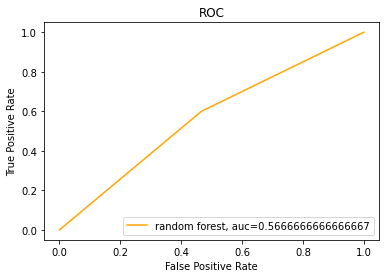

[I 2023-03-08 10:27:59,033] A new study created in memory with name: no-name-da8a2e7b-6430-45d6-ab1c-184d023bb843
[I 2023-03-08 10:28:01,246] Trial 0 finished with value: 0.58 and parameters: {'n_estimators': 1617, 'min_samoles_leaf': 8}. Best is trial 0 with value: 0.58.
[I 2023-03-08 10:28:03,628] Trial 1 finished with value: 0.58 and parameters: {'n_estimators': 1802, 'min_samoles_leaf': 15}. Best is trial 0 with value: 0.58.
[I 2023-03-08 10:28:05,069] Trial 2 finished with value: 0.56 and parameters: {'n_estimators': 1081, 'min_samoles_leaf': 12}. Best is trial 0 with value: 0.58.
[I 2023-03-08 10:28:06,076] Trial 3 finished with value: 0.58 and parameters: {'n_estimators': 758, 'min_samoles_leaf': 13}. Best is trial 0 with value: 0.58.
[I 2023-03-08 10:28:07,034] Trial 4 finished with value: 0.58 and parameters: {'n_estimators': 706, 'min_samoles_leaf': 7}. Best is trial 0 with value: 0.58.
[I 2023-03-08 10:28:09,461] Trial 5 finished with value: 0.56 and parameters: {'n_estimato

[I 2023-03-08 10:29:15,759] Trial 47 finished with value: 0.56 and parameters: {'n_estimators': 1588, 'min_samoles_leaf': 10}. Best is trial 0 with value: 0.58.
[I 2023-03-08 10:29:16,762] Trial 48 finished with value: 0.58 and parameters: {'n_estimators': 668, 'min_samoles_leaf': 7}. Best is trial 0 with value: 0.58.
[I 2023-03-08 10:29:17,036] Trial 49 finished with value: 0.58 and parameters: {'n_estimators': 178, 'min_samoles_leaf': 13}. Best is trial 0 with value: 0.58.
[I 2023-03-08 10:29:18,703] Trial 50 finished with value: 0.56 and parameters: {'n_estimators': 1174, 'min_samoles_leaf': 9}. Best is trial 0 with value: 0.58.
[I 2023-03-08 10:29:20,824] Trial 51 finished with value: 0.56 and parameters: {'n_estimators': 1580, 'min_samoles_leaf': 12}. Best is trial 0 with value: 0.58.
[I 2023-03-08 10:29:22,693] Trial 52 finished with value: 0.58 and parameters: {'n_estimators': 1404, 'min_samoles_leaf': 13}. Best is trial 0 with value: 0.58.
[I 2023-03-08 10:29:24,932] Trial 53 f

[I 2023-03-08 10:30:46,662] Trial 95 finished with value: 0.54 and parameters: {'n_estimators': 699, 'min_samoles_leaf': 5}. Best is trial 0 with value: 0.58.
[I 2023-03-08 10:30:48,024] Trial 96 finished with value: 0.58 and parameters: {'n_estimators': 984, 'min_samoles_leaf': 7}. Best is trial 0 with value: 0.58.
[I 2023-03-08 10:30:50,344] Trial 97 finished with value: 0.56 and parameters: {'n_estimators': 1666, 'min_samoles_leaf': 6}. Best is trial 0 with value: 0.58.
[I 2023-03-08 10:30:52,063] Trial 98 finished with value: 0.56 and parameters: {'n_estimators': 1248, 'min_samoles_leaf': 10}. Best is trial 0 with value: 0.58.
[I 2023-03-08 10:30:54,090] Trial 99 finished with value: 0.56 and parameters: {'n_estimators': 1498, 'min_samoles_leaf': 12}. Best is trial 0 with value: 0.58.


準確度： 0.58
最佳參數 {'n_estimators': 1617, 'min_samoles_leaf': 8}


In [29]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2018-01-01','2018-12-31',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)

auc_roc(y_test_RF, y_pre_RF)

from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)


[ 1  4  8 14 16]
              precision    recall  f1-score   support

           0       0.65      0.69      0.67        32
           1       0.33      0.29      0.31        17

    accuracy                           0.55        49
   macro avg       0.49      0.49      0.49        49
weighted avg       0.54      0.55      0.54        49

RandomForestClassifier
auc =  0.4908088235294118
accuracy: 0.5510204081632653


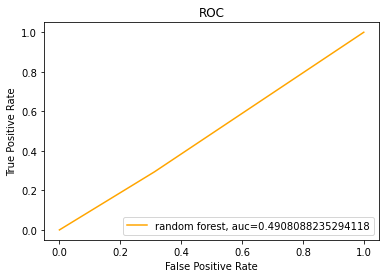

[I 2023-03-08 10:30:57,027] A new study created in memory with name: no-name-01f7010e-c4a1-4090-9636-bcf13d25272a
[I 2023-03-08 10:30:57,176] Trial 0 finished with value: 0.5510204081632653 and parameters: {'n_estimators': 104, 'min_samoles_leaf': 10}. Best is trial 0 with value: 0.5510204081632653.
[I 2023-03-08 10:30:57,413] Trial 1 finished with value: 0.5510204081632653 and parameters: {'n_estimators': 168, 'min_samoles_leaf': 6}. Best is trial 0 with value: 0.5510204081632653.
[I 2023-03-08 10:31:00,158] Trial 2 finished with value: 0.5510204081632653 and parameters: {'n_estimators': 1987, 'min_samoles_leaf': 9}. Best is trial 0 with value: 0.5510204081632653.
[I 2023-03-08 10:31:02,710] Trial 3 finished with value: 0.6122448979591837 and parameters: {'n_estimators': 1904, 'min_samoles_leaf': 11}. Best is trial 3 with value: 0.6122448979591837.
[I 2023-03-08 10:31:04,945] Trial 4 finished with value: 0.5510204081632653 and parameters: {'n_estimators': 1616, 'min_samoles_leaf': 5}.

[I 2023-03-08 10:31:55,374] Trial 40 finished with value: 0.6122448979591837 and parameters: {'n_estimators': 285, 'min_samoles_leaf': 14}. Best is trial 13 with value: 0.6530612244897959.
[I 2023-03-08 10:31:57,068] Trial 41 finished with value: 0.6530612244897959 and parameters: {'n_estimators': 1267, 'min_samoles_leaf': 13}. Best is trial 13 with value: 0.6530612244897959.
[I 2023-03-08 10:31:58,440] Trial 42 finished with value: 0.6326530612244898 and parameters: {'n_estimators': 1014, 'min_samoles_leaf': 12}. Best is trial 13 with value: 0.6530612244897959.
[I 2023-03-08 10:31:59,979] Trial 43 finished with value: 0.6122448979591837 and parameters: {'n_estimators': 1083, 'min_samoles_leaf': 15}. Best is trial 13 with value: 0.6530612244897959.
[I 2023-03-08 10:32:00,871] Trial 44 finished with value: 0.6122448979591837 and parameters: {'n_estimators': 631, 'min_samoles_leaf': 13}. Best is trial 13 with value: 0.6530612244897959.
[I 2023-03-08 10:32:02,170] Trial 45 finished with v

[I 2023-03-08 10:32:57,373] Trial 81 finished with value: 0.6530612244897959 and parameters: {'n_estimators': 1109, 'min_samoles_leaf': 13}. Best is trial 13 with value: 0.6530612244897959.
[I 2023-03-08 10:32:58,702] Trial 82 finished with value: 0.6530612244897959 and parameters: {'n_estimators': 993, 'min_samoles_leaf': 13}. Best is trial 13 with value: 0.6530612244897959.
[I 2023-03-08 10:33:00,399] Trial 83 finished with value: 0.6122448979591837 and parameters: {'n_estimators': 1259, 'min_samoles_leaf': 12}. Best is trial 13 with value: 0.6530612244897959.
[I 2023-03-08 10:33:01,970] Trial 84 finished with value: 0.6326530612244898 and parameters: {'n_estimators': 1171, 'min_samoles_leaf': 14}. Best is trial 13 with value: 0.6530612244897959.
[I 2023-03-08 10:33:03,366] Trial 85 finished with value: 0.6530612244897959 and parameters: {'n_estimators': 1042, 'min_samoles_leaf': 13}. Best is trial 13 with value: 0.6530612244897959.
[I 2023-03-08 10:33:04,949] Trial 86 finished with 

準確度： 0.6530612244897959
最佳參數 {'n_estimators': 989, 'min_samoles_leaf': 13}


In [30]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2019-01-01','2019-12-31',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)

auc_roc(y_test_RF, y_pre_RF)

from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)


[3 4 5 8 9]
              precision    recall  f1-score   support

           0       0.61      0.38      0.47        29
           1       0.42      0.65      0.51        20

    accuracy                           0.49        49
   macro avg       0.52      0.51      0.49        49
weighted avg       0.53      0.49      0.49        49

RandomForestClassifier
auc =  0.5146551724137931
accuracy: 0.4897959183673469


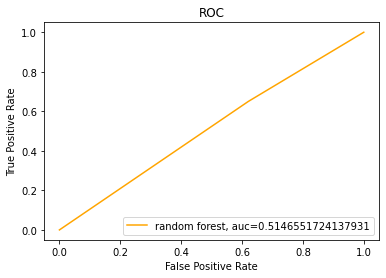

[I 2023-03-08 10:33:26,682] A new study created in memory with name: no-name-fba69ff7-d0b7-42b1-946c-f3c4aaa40472
[I 2023-03-08 10:33:27,151] Trial 0 finished with value: 0.4897959183673469 and parameters: {'n_estimators': 348, 'min_samoles_leaf': 15}. Best is trial 0 with value: 0.4897959183673469.
[I 2023-03-08 10:33:28,640] Trial 1 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 1113, 'min_samoles_leaf': 12}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:33:29,532] Trial 2 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 654, 'min_samoles_leaf': 9}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:33:30,728] Trial 3 finished with value: 0.4897959183673469 and parameters: {'n_estimators': 862, 'min_samoles_leaf': 15}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:33:31,543] Trial 4 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 599, 'min_samoles_leaf': 12}.

[I 2023-03-08 10:34:22,941] Trial 41 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 1235, 'min_samoles_leaf': 11}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:34:24,286] Trial 42 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 995, 'min_samoles_leaf': 12}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:34:25,778] Trial 43 finished with value: 0.4897959183673469 and parameters: {'n_estimators': 1118, 'min_samoles_leaf': 13}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:34:27,574] Trial 44 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 1327, 'min_samoles_leaf': 11}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:34:30,109] Trial 45 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 1854, 'min_samoles_leaf': 7}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:34:31,199] Trial 46 finished with value:

[I 2023-03-08 10:35:19,836] Trial 82 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 1542, 'min_samoles_leaf': 10}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:35:21,768] Trial 83 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 1393, 'min_samoles_leaf': 9}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:35:23,370] Trial 84 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 1182, 'min_samoles_leaf': 12}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:35:25,835] Trial 85 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 1780, 'min_samoles_leaf': 11}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:35:28,020] Trial 86 finished with value: 0.5102040816326531 and parameters: {'n_estimators': 1606, 'min_samoles_leaf': 11}. Best is trial 1 with value: 0.5102040816326531.
[I 2023-03-08 10:35:30,541] Trial 87 finished with value

準確度： 0.5102040816326531
最佳參數 {'n_estimators': 1113, 'min_samoles_leaf': 12}


In [31]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2020-01-01','2020-12-31',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)

auc_roc(y_test_RF, y_pre_RF)

from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)


[ 2  6 10 11 14]
              precision    recall  f1-score   support

           0       0.61      0.69      0.65        29
           1       0.44      0.35      0.39        20

    accuracy                           0.55        49
   macro avg       0.52      0.52      0.52        49
weighted avg       0.54      0.55      0.54        49

RandomForestClassifier
auc =  0.5198275862068966
accuracy: 0.5510204081632653


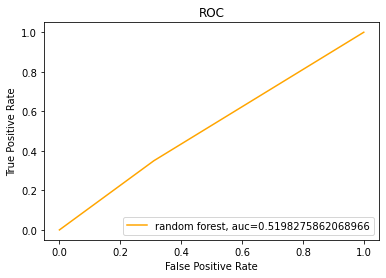

[I 2023-03-08 10:35:49,080] A new study created in memory with name: no-name-e5566d33-9e90-4371-94d9-eba18d3cae47
[I 2023-03-08 10:35:49,922] Trial 0 finished with value: 0.5918367346938775 and parameters: {'n_estimators': 585, 'min_samoles_leaf': 12}. Best is trial 0 with value: 0.5918367346938775.
[I 2023-03-08 10:35:51,027] Trial 1 finished with value: 0.5510204081632653 and parameters: {'n_estimators': 812, 'min_samoles_leaf': 8}. Best is trial 0 with value: 0.5918367346938775.
[I 2023-03-08 10:35:53,626] Trial 2 finished with value: 0.5510204081632653 and parameters: {'n_estimators': 1885, 'min_samoles_leaf': 6}. Best is trial 0 with value: 0.5918367346938775.
[I 2023-03-08 10:35:56,219] Trial 3 finished with value: 0.5510204081632653 and parameters: {'n_estimators': 1706, 'min_samoles_leaf': 6}. Best is trial 0 with value: 0.5918367346938775.
[I 2023-03-08 10:35:57,876] Trial 4 finished with value: 0.5510204081632653 and parameters: {'n_estimators': 1217, 'min_samoles_leaf': 11}.

[I 2023-03-08 10:36:35,868] Trial 41 finished with value: 0.5918367346938775 and parameters: {'n_estimators': 1367, 'min_samoles_leaf': 13}. Best is trial 0 with value: 0.5918367346938775.
[I 2023-03-08 10:36:37,575] Trial 42 finished with value: 0.5918367346938775 and parameters: {'n_estimators': 1274, 'min_samoles_leaf': 13}. Best is trial 0 with value: 0.5918367346938775.
[I 2023-03-08 10:36:39,183] Trial 43 finished with value: 0.5918367346938775 and parameters: {'n_estimators': 1178, 'min_samoles_leaf': 12}. Best is trial 0 with value: 0.5918367346938775.
[I 2023-03-08 10:36:40,689] Trial 44 finished with value: 0.5918367346938775 and parameters: {'n_estimators': 1079, 'min_samoles_leaf': 14}. Best is trial 0 with value: 0.5918367346938775.
[I 2023-03-08 10:36:42,130] Trial 45 finished with value: 0.5918367346938775 and parameters: {'n_estimators': 1068, 'min_samoles_leaf': 15}. Best is trial 0 with value: 0.5918367346938775.
[I 2023-03-08 10:36:44,331] Trial 46 finished with valu

[I 2023-03-08 10:37:23,145] Trial 82 finished with value: 0.5918367346938775 and parameters: {'n_estimators': 352, 'min_samoles_leaf': 15}. Best is trial 0 with value: 0.5918367346938775.
[I 2023-03-08 10:37:23,768] Trial 83 finished with value: 0.5510204081632653 and parameters: {'n_estimators': 436, 'min_samoles_leaf': 5}. Best is trial 0 with value: 0.5918367346938775.
[I 2023-03-08 10:37:24,014] Trial 84 finished with value: 0.5918367346938775 and parameters: {'n_estimators': 167, 'min_samoles_leaf': 15}. Best is trial 0 with value: 0.5918367346938775.
[I 2023-03-08 10:37:24,958] Trial 85 finished with value: 0.5918367346938775 and parameters: {'n_estimators': 699, 'min_samoles_leaf': 14}. Best is trial 0 with value: 0.5918367346938775.
[I 2023-03-08 10:37:26,223] Trial 86 finished with value: 0.5918367346938775 and parameters: {'n_estimators': 938, 'min_samoles_leaf': 15}. Best is trial 0 with value: 0.5918367346938775.
[I 2023-03-08 10:37:27,066] Trial 87 finished with value: 0.5

準確度： 0.5918367346938775
最佳參數 {'n_estimators': 585, 'min_samoles_leaf': 12}


In [32]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2021-01-01','2021-12-31',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)

auc_roc(y_test_RF, y_pre_RF)

from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)


[1 2 3 4 7]
              precision    recall  f1-score   support

           0       0.58      0.27      0.37        26
           1       0.42      0.74      0.54        19

    accuracy                           0.47        45
   macro avg       0.50      0.50      0.45        45
weighted avg       0.52      0.47      0.44        45

RandomForestClassifier
auc =  0.5030364372469636
accuracy: 0.4666666666666667


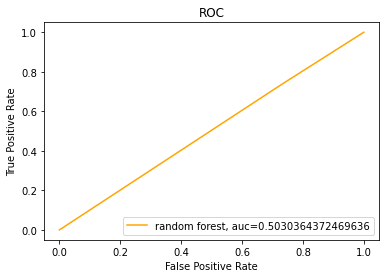

[I 2023-03-08 10:37:41,910] A new study created in memory with name: no-name-19e135db-afbc-480c-b3fb-0ed192b301cf
[I 2023-03-08 10:37:42,065] Trial 0 finished with value: 0.4888888888888889 and parameters: {'n_estimators': 105, 'min_samoles_leaf': 8}. Best is trial 0 with value: 0.4888888888888889.
[I 2023-03-08 10:37:43,247] Trial 1 finished with value: 0.4444444444444444 and parameters: {'n_estimators': 821, 'min_samoles_leaf': 10}. Best is trial 0 with value: 0.4888888888888889.
[I 2023-03-08 10:37:43,794] Trial 2 finished with value: 0.4444444444444444 and parameters: {'n_estimators': 352, 'min_samoles_leaf': 12}. Best is trial 0 with value: 0.4888888888888889.
[I 2023-03-08 10:37:44,677] Trial 3 finished with value: 0.4888888888888889 and parameters: {'n_estimators': 575, 'min_samoles_leaf': 5}. Best is trial 0 with value: 0.4888888888888889.
[I 2023-03-08 10:37:46,027] Trial 4 finished with value: 0.4888888888888889 and parameters: {'n_estimators': 788, 'min_samoles_leaf': 9}. Be

[I 2023-03-08 10:38:48,127] Trial 41 finished with value: 0.5111111111111111 and parameters: {'n_estimators': 1176, 'min_samoles_leaf': 9}. Best is trial 13 with value: 0.5111111111111111.
[I 2023-03-08 10:38:50,136] Trial 42 finished with value: 0.5111111111111111 and parameters: {'n_estimators': 1441, 'min_samoles_leaf': 8}. Best is trial 13 with value: 0.5111111111111111.
[I 2023-03-08 10:38:51,744] Trial 43 finished with value: 0.4444444444444444 and parameters: {'n_estimators': 1107, 'min_samoles_leaf': 11}. Best is trial 13 with value: 0.5111111111111111.
[I 2023-03-08 10:38:53,512] Trial 44 finished with value: 0.4222222222222222 and parameters: {'n_estimators': 1274, 'min_samoles_leaf': 12}. Best is trial 13 with value: 0.5111111111111111.
[I 2023-03-08 10:38:54,763] Trial 45 finished with value: 0.5111111111111111 and parameters: {'n_estimators': 905, 'min_samoles_leaf': 9}. Best is trial 13 with value: 0.5111111111111111.
[I 2023-03-08 10:38:57,006] Trial 46 finished with val

[I 2023-03-08 10:39:55,635] Trial 82 finished with value: 0.5111111111111111 and parameters: {'n_estimators': 1684, 'min_samoles_leaf': 8}. Best is trial 13 with value: 0.5111111111111111.
[I 2023-03-08 10:39:57,563] Trial 83 finished with value: 0.5111111111111111 and parameters: {'n_estimators': 1338, 'min_samoles_leaf': 9}. Best is trial 13 with value: 0.5111111111111111.
[I 2023-03-08 10:39:59,781] Trial 84 finished with value: 0.4444444444444444 and parameters: {'n_estimators': 1607, 'min_samoles_leaf': 10}. Best is trial 13 with value: 0.5111111111111111.
[I 2023-03-08 10:40:02,163] Trial 85 finished with value: 0.4888888888888889 and parameters: {'n_estimators': 1737, 'min_samoles_leaf': 8}. Best is trial 13 with value: 0.5111111111111111.
[I 2023-03-08 10:40:03,654] Trial 86 finished with value: 0.5111111111111111 and parameters: {'n_estimators': 1050, 'min_samoles_leaf': 9}. Best is trial 13 with value: 0.5111111111111111.
[I 2023-03-08 10:40:05,347] Trial 87 finished with val

準確度： 0.5111111111111111
最佳參數 {'n_estimators': 1179, 'min_samoles_leaf': 6}


In [33]:
data = data_process(data)

X_train,X_test,y_train,y_test = split_data(data,'2022-01-01','2022-11-30',['股價漲跌幅','布林通道帶寬','SMA5','SMA10','SMA20','SMA60','EMA5','EMA10','EMA20','EMA60','K','D','RSI5','RSI10','MACD','WILLAR5','WILLAR10'],5)

y_test_RF, y_pre_RF = RandomForest(X_train,X_test,y_train,y_test)

auc_roc(y_test_RF, y_pre_RF)

from sklearn.ensemble import RandomForestClassifier
import optuna
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators',100,2000)
    min_samples_leaf = trial.suggest_int('min_samoles_leaf',5,15)
    
    svc_new = RandomForestClassifier(n_estimators = n_estimators, random_state=10, n_jobs=-1 , min_samples_leaf=min_samples_leaf)
    svc_new.fit(X_train ,np.ravel(y_train))
    from sklearn import metrics
    from sklearn.metrics import accuracy_score
    y_pre_new = svc_new.predict(X_test)
    auc_optuna = accuracy_score(y_test ,y_pre_new )
    
    return(auc_optuna)

study = optuna.create_study(direction= "maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_accuracy = best_trial.value

best_params = study.best_params
print('準確度：',best_accuracy)
print('最佳參數',best_params)
